In [28]:
# === Libraries ===
import os
import re
from collections import Counter, defaultdict
from itertools import product
from pprint import pprint
import nltk
from nltk.tokenize import word_tokenize
from nltk.util import ngrams
from nltk.corpus import stopwords
nltk.download('punkt')
import spacy
nlp = spacy.load("en_core_web_sm")
nlp.max_length = 6_000_000
from bertopic import BERTopic
from bertopic._utils import check_is_fitted
import hdbscan
from sentence_transformers import SentenceTransformer
from textstat import flesch_reading_ease
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, ENGLISH_STOP_WORDS
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import pandas as pd
import numpy as np
from langchain.prompts import ChatPromptTemplate
from langchain_ollama import OllamaLLM
from gensim.models.coherencemodel import CoherenceModel
from gensim.corpora import Dictionary
from octis.evaluation_metrics.diversity_metrics import TopicDiversity
from tqdm import tqdm
os.environ["TOKENIZERS_PARALLELISM"] = "false"

[nltk_data] Downloading package punkt to /home/jacobhardy/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [34]:
# === Load data ===
col_to_care = 'descr'  # change according to the column containing the text you wish to analyze
data = pd.read_csv('BBCNews.csv', usecols=[col_to_care])
docs = data[col_to_care].dropna().astype(str).tolist()

In [35]:
# === Verified Topics ===

df = pd.read_csv('BBCNews.csv')

# Extract just the first topic from each row
first_topics = df['tags'].astype(str).apply(lambda x: x.split(',')[0].strip())

# Get list (optional)
first_topics_list = first_topics.tolist()

# Count occurrences of each first topic
first_topic_counts = Counter(first_topics_list)

# Convert to DataFrame (if desired)
first_topic_counts_df = pd.DataFrame(first_topic_counts.items(), columns=["Topic", "Count"]).sort_values(by="Count", ascending=False)

# Display summary
print(first_topic_counts_df.head(12))
print(f"Total Topics: {len(set(first_topics_list))}")

# Sort topics by count descending
sorted_topics = first_topic_counts_df.sort_values(by="Count", ascending=False).reset_index(drop=True)

# Find index of "health"
health_index = sorted_topics[sorted_topics["Topic"].str.lower() == "health"].index[0]

# Sum all counts after "health"
remaining_sum = sorted_topics.loc[health_index+1:, "Count"].sum()

print(f"Total count of topics after 'health': {remaining_sum}")


             Topic  Count
0           sports    475
36   entertainment    413
11        business    399
33      technology    391
9         politics    294
18             law     61
14   social issues     56
3   human interest     31
12        disaster     27
24           labor     19
1        education     17
21          health     17
Total Topics: 127
Total count of topics after 'health': 227


          Word  Frequency  Avg TF per Doc  Doc Freq Ratio
0       people       2387        0.990456        0.378838
1          new       2194        0.910373        0.447718
2         year       1785        0.740664        0.418672
3        years       1313        0.544813        0.346473
4         time       1277        0.529876        0.337344
5        world       1104        0.458091        0.261411
6         make       1075        0.446058        0.292946
7         just       1071        0.444398        0.276349
8   government       1042        0.432365        0.189627
9        music        998        0.414108        0.120332
10        like        969        0.402075        0.247718
11        game        961        0.398755        0.151867
12        told        961        0.398755        0.273029
13        best        957        0.397095        0.158506
14        film        858        0.356017        0.106639
15      number        855        0.354772        0.226971
16         way

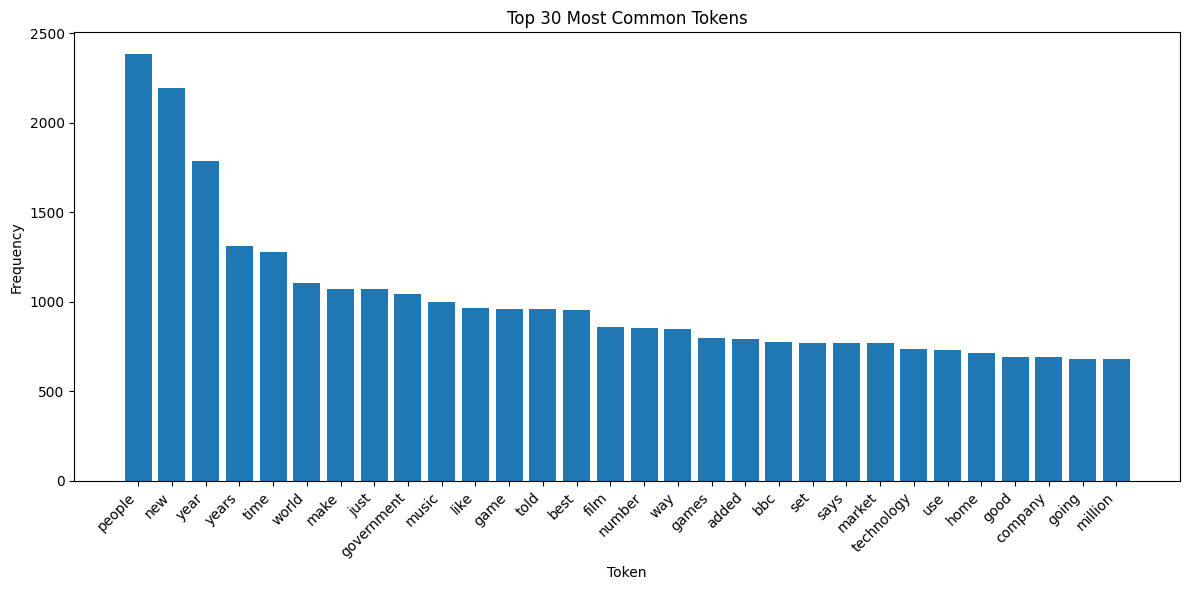

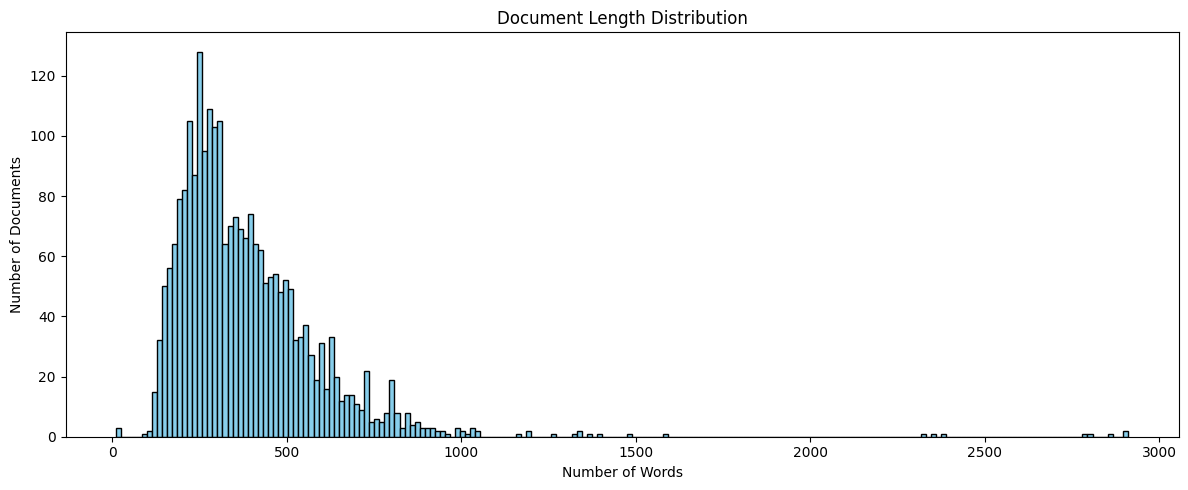

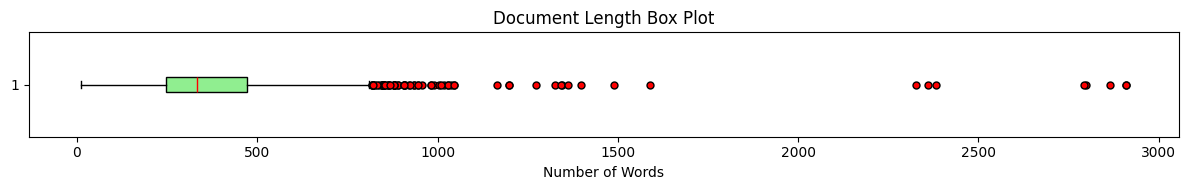

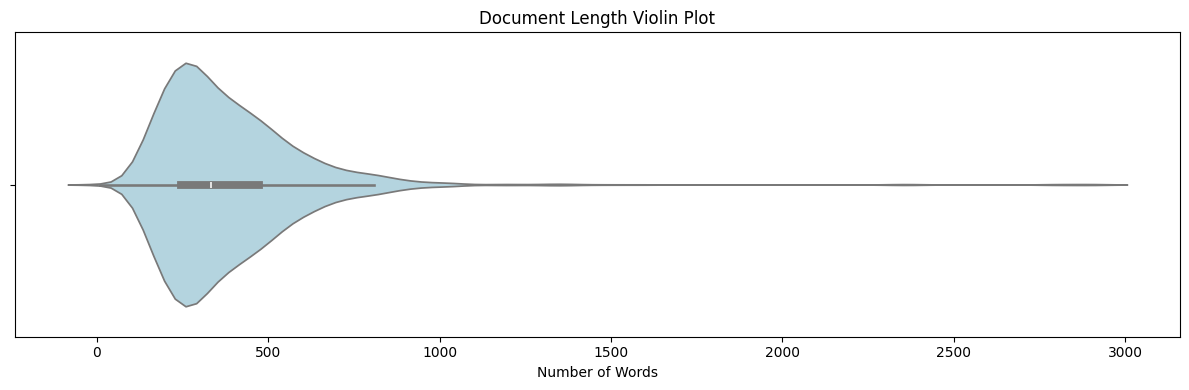


Top 30 Bigrams:
told bbc: 381
prime minister: 277
chief executive: 216
bbc news: 215
general election: 172
tony blair: 165
new york: 164
years ago: 138
mobile phone: 133
news website: 126
human rights: 119
michael howard: 115
bbc radio: 114
lib dems: 106
mobile phones: 104
home secretary: 100
gordon brown: 100
new zealand: 96
liberal democrats: 94
box office: 90
world cup: 87
mac mini: 84
digital music: 81
economic growth: 80
grand slam: 78
manchester united: 75
tory leader: 75
lib dem: 74
stock market: 74
make sure: 72

Top 30 Trigrams:
told bbc news: 177
bbc news website: 125
told bbc radio: 76
leader michael howard: 55
million dollar baby: 50
radio today programme: 49
told bbc sport: 48
bbc radio today: 47
tory leader michael: 41
digital music players: 34
prime minister tony: 33
leader charles kennedy: 32
bbc world service: 28
coach andy robinson: 27
minister tony blair: 27
chancellor gordon brown: 27
london stock exchange: 27
deputy prime minister: 23
sir alex ferguson: 22
foreign

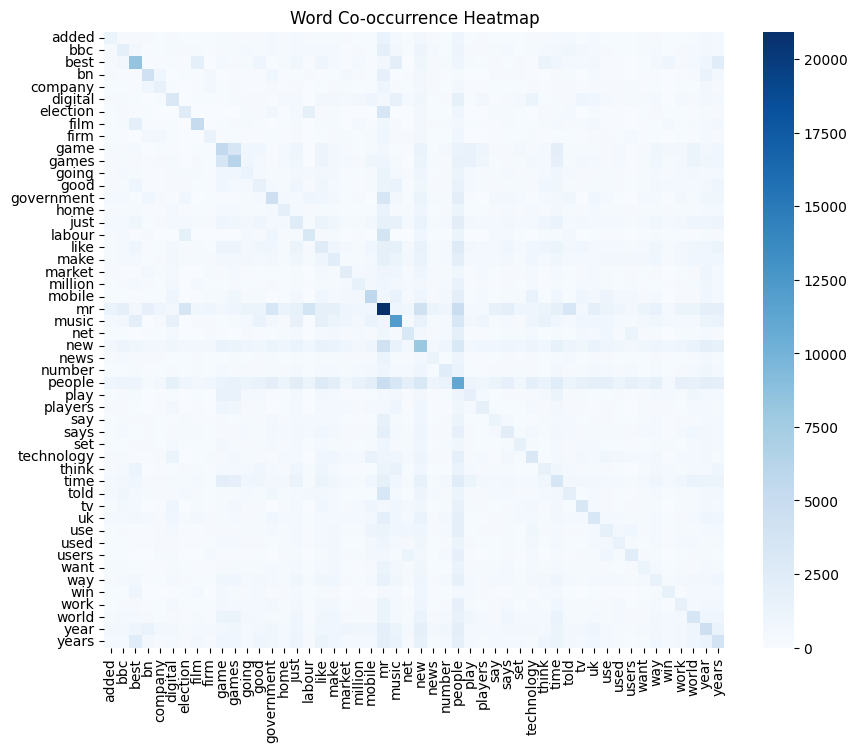

          Word      TF-IDF
14          mr  376.028314
16         new  293.750953
18      people  289.944199
28        year  275.211051
29       years  208.636721
22        time  201.489233
27       world  190.117783
3           bn  184.708120
12        make  177.099258
8   government  175.082237
count    2410.000000
mean     -315.443460
std       229.017685
min     -2866.912113
25%      -406.135664
50%      -265.446676
75%      -174.708866
max        72.615455
Name: readability, dtype: float64


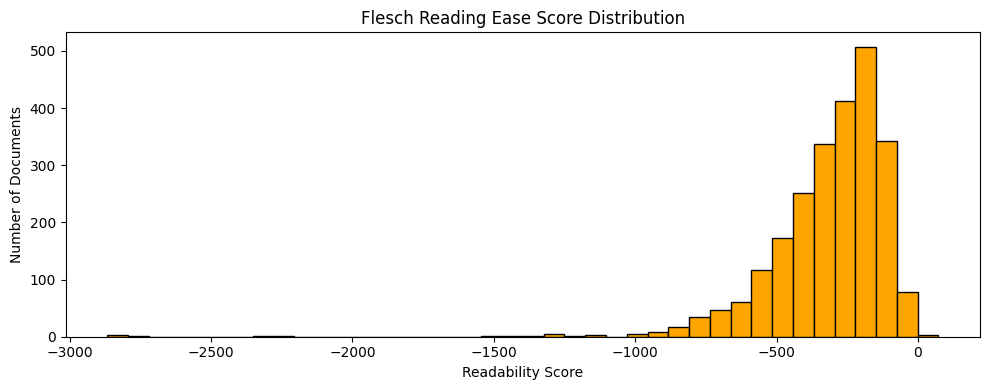


Doc 556 — Readability: -2866.91
losing yourself in online gaming online role playing games are timeconsuming but enthralling flights from reality but are some people taking their fantasy lives too seriously when video game world of warcraft hit the shops in europe last week fans wrote in to the bbc website to express their delight and to offer a warning an addiction to a game like this is far more costly in time than any substance could impair keep track of time wrote travis anderson in texas some of the comments were humorous this game is so good im not going to get it theres no way i could limit the hours id spend playing it wrote charles macintyre from england but some struck a more worrying tone about the massively multiplayer online role playing game mmorpg you need to get out more could be the motto of any mmorpg shame they are getting more popular as you know this problem is just going to mushroom wrote stuart stantondavies in huddersfield scaremongering articles about addictiv

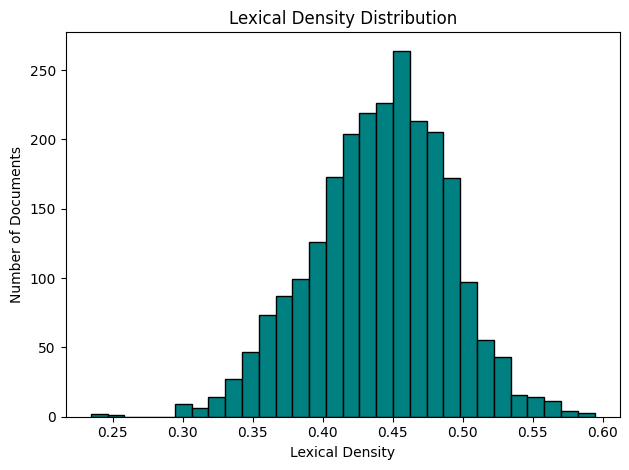


EDA Summary:
{'Average Length (words)': 384.1352697095436,
 'Duplicate Descriptions': 282,
 'Max Length (words)': 2910,
 'Min Length (words)': 11,
 'Missing Descriptions': 0,
 'Total Documents': 2410}


In [36]:
# === EDA ===

# === Custom Stopwords ===
custom_stopwords = list(ENGLISH_STOP_WORDS.union({
    'flight', 'airline', 'airways', 'ba', 'british', 'seat', 'said'
}))

# === Tokenization Function ===
def tokenize(text):
    return re.findall(r'\b[a-z]{3,}\b', text.lower())

# === Apply Tokenization + Stopword Removal ===
tokens = [token for doc in data[col_to_care].dropna().astype(str)
          for token in tokenize(doc) if token not in custom_stopwords]

# === Word Frequencies ===
token_counts = Counter(tokens)

doc_freq = defaultdict(int)
for doc in data[col_to_care].dropna().astype(str):
    unique_tokens = set(tokenize(doc))
    for token in unique_tokens:
        doc_freq[token] += 1

num_docs = len(data)

common_tokens = token_counts.most_common(30)
common_df = pd.DataFrame(common_tokens, columns=["Word", "Frequency"])

common_df["Avg TF per Doc"] = common_df["Frequency"] / num_docs
common_df["Doc Freq Ratio"] = common_df["Word"].apply(lambda w: doc_freq[w] / num_docs)

print(common_df)

# === Word Cloud ===
text_blob = " ".join(data[col_to_care].dropna().astype(str).tolist())
wordcloud = WordCloud(width=800, height=400, background_color='white',
                      stopwords=custom_stopwords).generate(text_blob)

wordcloud.to_image().show()

# === Bar Plot for Top Tokens ===
plt.figure(figsize=(12, 6))
plt.bar(common_df["Word"], common_df["Frequency"])
plt.xticks(rotation=45, ha='right')
plt.title("Top 30 Most Common Tokens")
plt.xlabel("Token")
plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

# === Document Lengths ===
doc_lengths = data[col_to_care].dropna().astype(str).apply(lambda x: len(x.split()))

# === Histogram ===
plt.figure(figsize=(12, 5))
plt.hist(doc_lengths, bins=200, color='skyblue', edgecolor='black')
plt.title("Document Length Distribution")
plt.xlabel("Number of Words")
plt.ylabel("Number of Documents")
plt.tight_layout()
plt.show()

# === Box Plot ===
plt.figure(figsize=(12, 2))
plt.boxplot(doc_lengths, vert=False, patch_artist=True,
            boxprops=dict(facecolor='lightgreen', color='black'),
            medianprops=dict(color='red'),
            whiskerprops=dict(color='black'),
            capprops=dict(color='black'),
            flierprops=dict(markerfacecolor='red', marker='o', markersize=5))
plt.title("Document Length Box Plot")
plt.xlabel("Number of Words")
plt.tight_layout()
plt.show()

# === Violin Graph ===
plt.figure(figsize=(12, 4))
sns.violinplot(data=doc_lengths, orient='h', inner='box', color='lightblue')
plt.title("Document Length Violin Plot")
plt.xlabel("Number of Words")
plt.tight_layout()
plt.show()

# === Bigrams ===
bigram_tokens = list(ngrams(tokens, 2))
bigram_counts = Counter(bigram_tokens)
print("\nTop 30 Bigrams:")
for bigram, freq in bigram_counts.most_common(30):
    print(f"{' '.join(bigram)}: {freq}")

# === Trigrams ===
trigram_tokens = list(ngrams(tokens, 3))
trigram_counts = Counter(trigram_tokens)
print("\nTop 30 Trigrams:")
for trigram, freq in trigram_counts.most_common(30):
    print(f"{' '.join(trigram)}: {freq}")

# === n_grams ===
corpus = data[col_to_care].dropna().astype(str).tolist()
vectorizer = CountVectorizer(
    stop_words=custom_stopwords,
    ngram_range=(4, 10),
    max_features=1000  
)
X = vectorizer.fit_transform(corpus)
ngram_freq = zip(vectorizer.get_feature_names_out(), X.sum(axis=0).A1)
ngram_df = pd.DataFrame(ngram_freq, columns=["N-gram", "Frequency"])
ngram_df = ngram_df.sort_values(by="Frequency", ascending=False)

print("\nTop 30 N-grams (4 to 10 words):")
print(ngram_df.head(30))


# === Word Co-occurance heatmap matrix
vectorizer = CountVectorizer(stop_words=custom_stopwords, max_features=50)
X = vectorizer.fit_transform(data[col_to_care].dropna())
co_matrix = (X.T @ X).toarray()
words = vectorizer.get_feature_names_out()

plt.figure(figsize=(10, 8))
sns.heatmap(co_matrix, xticklabels=words, yticklabels=words, cmap='Blues')
plt.title("Word Co-occurrence Heatmap")
plt.show()

# === TF-IDF ===
tfidf = TfidfVectorizer(stop_words=custom_stopwords, max_features=30)
tfidf_matrix = tfidf.fit_transform(data[col_to_care].dropna().astype(str))
tfidf_scores = tfidf_matrix.sum(axis=0).A1
tfidf_vocab = tfidf.get_feature_names_out()

tfidf_df = pd.DataFrame({'Word': tfidf_vocab, 'TF-IDF': tfidf_scores})
print(tfidf_df.sort_values(by='TF-IDF', ascending=False).head(10))

# === LRR (lexical richness and readability) ===
def clean_text_for_readability(text):
    text = re.sub(r'\s+', ' ', text)  
    text = re.sub(r'[^a-zA-Z0-9.,!?;:\'"\s]', '', text) 
    return text.strip()

data['clean_col_to_care'] = data[col_to_care].astype(str).apply(clean_text_for_readability)
data['readability'] = data['clean_col_to_care'].apply(flesch_reading_ease)

print(data['readability'].describe())

plt.figure(figsize=(10, 4))
plt.hist(data['readability'], bins=40, color='orange', edgecolor='black')
plt.title("Flesch Reading Ease Score Distribution")
plt.xlabel("Readability Score")
plt.ylabel("Number of Documents")
plt.tight_layout()
plt.show()

lowest = data.sort_values(by='readability').head(3)
for i, row in lowest.iterrows():
    print(f"\nDoc {i} — Readability: {row['readability']:.2f}")
    print(row['clean_col_to_care'])


# === NER (named entity recognition) ===
all_ents = []
for doc in nlp.pipe(data[col_to_care].dropna().tolist(), batch_size=8):
    all_ents.extend([(ent.text, ent.label_) for ent in doc.ents])

ent_df = pd.DataFrame(all_ents, columns=["Text", "Label"])
top_entities = ent_df['Label'].value_counts().head(10)
print("\nTop Entity Labels:")
print(top_entities)

top_entity_texts = ent_df.groupby("Label")['Text'].value_counts().groupby(level=0).head(3)
print("\nSample Top Entities:")
print(top_entity_texts)


# === Lexical Density ===
def compute_lexical_density(text):
    doc = nlp(text)
    content_words = [token for token in doc if token.pos_ in {"NOUN", "VERB", "ADJ", "ADV"} and not token.is_stop]
    total_words = [token for token in doc if token.is_alpha]
    if len(total_words) == 0:
        return 0
    return len(content_words) / len(total_words)

data['lexical_density'] = data[col_to_care].apply(compute_lexical_density)

# === Corpus-level POS Tag Percentages ===
full_text = " ".join(data[col_to_care].tolist())
doc = nlp(full_text)

pos_counts = Counter(token.pos_ for token in doc if token.is_alpha)
total_tokens = sum(pos_counts.values())

pos_df = pd.DataFrame({
    "POS": list(pos_counts.keys()),
    "Count": list(pos_counts.values()),
})
pos_df["Percent"] = (pos_df["Count"] / total_tokens * 100).round(2)
pos_df = pos_df.sort_values(by="Percent", ascending=False)

print("\nCorpus POS Composition (% of all alphabetic tokens):")
print(pos_df)

# === Lexical Density Summary ===
print("\nCorpus Lexical Density Summary:")
print(data['lexical_density'].describe())

# === Lexical Density Histogram ===
plt.hist(data['lexical_density'], bins=30, color='teal', edgecolor='black')
plt.title("Lexical Density Distribution")
plt.xlabel("Lexical Density")
plt.ylabel("Number of Documents")
plt.tight_layout()
plt.show()


# === Summary Stats ===
eda_summary = {
    "Total Documents": len(data),
    "Missing Descriptions": data[col_to_care].isnull().sum(),
    "Duplicate Descriptions": data.duplicated(subset=col_to_care).sum(),
    "Average Length (words)": doc_lengths.mean(),
    "Max Length (words)": doc_lengths.max(),
    "Min Length (words)": doc_lengths.min(),
}
print("\nEDA Summary:")
pprint(eda_summary)


In [37]:
# === Preprocess ===
def clean_text(text):
    text = re.sub(r"http\S+|www\S+", '', text)  # remove URLs
    text = re.sub(r"[^a-zA-Z0-9.,!?;:'\"()\[\]\- ]+", '', text)  # remove special chars
    text = re.sub(r"\s+", ' ', text)  # collapse whitespace
    return text.strip()

docs = list(set(clean_text(doc) for doc in docs))

docs = [clean_text(doc) for doc in docs]


In [38]:
# === Load embedding model ===
model = SentenceTransformer("BAAI/bge-large-en-v1.5", device="cuda")

max_words = 128
overlap = 32
min_words = 25
prompt = "Represent the document for clustering:"

final_embeddings = []
final_docs = []

for doc in tqdm(docs):
    cleaned = clean_text(doc)  

    words = cleaned.split()
    chunks = []
    i = 0
    while i < len(words):
        chunk = words[i:i + max_words]
        if len(chunk) >= min_words:
            chunks.append(" ".join(chunk))
        i += max_words - overlap

    if not chunks:
        continue

    prompted_chunks = [f"{prompt} {chunk}" for chunk in chunks]
    chunk_embeddings = model.encode(
        prompted_chunks,
        convert_to_numpy=True,
        show_progress_bar=True,
        batch_size=8
    )

    chunk_lengths = [len(chunk.split()) for chunk in chunks]
    weights = np.array(chunk_lengths) / sum(chunk_lengths)

    pooled_embedding = np.average(chunk_embeddings, axis=0, weights=weights)

    norm = np.linalg.norm(pooled_embedding)
    if norm > 0:
        pooled_embedding = pooled_embedding / norm

    final_embeddings.append(pooled_embedding)
    final_docs.append(doc)

final_embeddings = np.array(final_embeddings)

  0%|                                                  | 0/2126 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

  0%|                                          | 3/2126 [00:00<01:20, 26.53it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

  0%|                                          | 6/2126 [00:00<01:33, 22.66it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

  0%|▏                                         | 9/2126 [00:00<01:37, 21.62it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

  1%|▏                                        | 12/2126 [00:00<01:32, 22.80it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

  1%|▎                                        | 15/2126 [00:00<01:31, 23.15it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

  1%|▎                                        | 18/2126 [00:00<01:29, 23.68it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

  1%|▍                                        | 21/2126 [00:00<01:33, 22.63it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

  1%|▍                                        | 24/2126 [00:01<01:30, 23.24it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

  1%|▌                                        | 27/2126 [00:01<01:31, 23.03it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

  1%|▌                                        | 30/2126 [00:01<01:32, 22.77it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

  2%|▋                                        | 33/2126 [00:01<01:25, 24.47it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

  2%|▋                                        | 36/2126 [00:01<01:22, 25.38it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

  2%|▊                                        | 39/2126 [00:01<01:27, 23.83it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

  2%|▊                                        | 42/2126 [00:01<01:24, 24.58it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

  2%|▊                                        | 45/2126 [00:01<01:20, 25.86it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

  2%|▉                                        | 48/2126 [00:01<01:17, 26.76it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

  2%|█                                        | 52/2126 [00:02<01:14, 27.90it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

  3%|█                                        | 55/2126 [00:02<01:12, 28.44it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

  3%|█                                        | 58/2126 [00:02<01:11, 28.82it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

  3%|█▏                                       | 61/2126 [00:02<01:15, 27.38it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

  3%|█▏                                       | 64/2126 [00:02<01:17, 26.53it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

  3%|█▎                                       | 68/2126 [00:02<01:14, 27.49it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

  3%|█▎                                       | 71/2126 [00:02<01:19, 25.76it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

  3%|█▍                                       | 74/2126 [00:02<01:23, 24.69it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

  4%|█▍                                       | 77/2126 [00:03<01:25, 24.03it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

  4%|█▌                                       | 80/2126 [00:03<01:20, 25.28it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

  4%|█▌                                       | 83/2126 [00:03<01:19, 25.59it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

  4%|█▋                                       | 86/2126 [00:03<01:22, 24.84it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

  4%|█▋                                       | 89/2126 [00:03<01:19, 25.54it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

  4%|█▊                                       | 92/2126 [00:03<01:30, 22.58it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

  4%|█▊                                       | 95/2126 [00:03<01:28, 22.84it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

  5%|█▉                                       | 98/2126 [00:03<01:24, 23.97it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

  5%|█▉                                      | 101/2126 [00:04<01:23, 24.31it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

  5%|█▉                                      | 104/2126 [00:04<01:25, 23.65it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

  5%|██                                      | 107/2126 [00:04<01:36, 20.99it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

  5%|██                                      | 110/2126 [00:04<01:37, 20.71it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

  5%|██▏                                     | 113/2126 [00:04<01:36, 20.81it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

  5%|██▏                                     | 116/2126 [00:04<01:30, 22.13it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

  6%|██▏                                     | 119/2126 [00:04<01:35, 20.97it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

  6%|██▎                                     | 122/2126 [00:05<01:36, 20.66it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

  6%|██▎                                     | 125/2126 [00:05<01:34, 21.25it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

  6%|██▍                                     | 128/2126 [00:05<01:35, 20.92it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

  6%|██▍                                     | 131/2126 [00:05<01:41, 19.69it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

  6%|██▌                                     | 134/2126 [00:05<01:33, 21.24it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

  6%|██▌                                     | 137/2126 [00:05<01:36, 20.56it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

  7%|██▋                                     | 140/2126 [00:05<01:31, 21.67it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

  7%|██▋                                     | 143/2126 [00:06<01:29, 22.08it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

  7%|██▋                                     | 146/2126 [00:06<01:30, 21.80it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

  7%|██▊                                     | 149/2126 [00:06<01:25, 23.25it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

  7%|██▊                                     | 152/2126 [00:06<01:20, 24.64it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

  7%|██▉                                     | 156/2126 [00:06<01:10, 28.11it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

  8%|███                                     | 160/2126 [00:06<01:09, 28.27it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

  8%|███                                     | 163/2126 [00:06<01:11, 27.60it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

  8%|███                                     | 166/2126 [00:06<01:11, 27.40it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

  8%|███▏                                    | 169/2126 [00:07<01:12, 26.99it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

  8%|███▏                                    | 172/2126 [00:07<01:11, 27.30it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

  8%|███▎                                    | 175/2126 [00:07<01:13, 26.58it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

  8%|███▎                                    | 178/2126 [00:07<01:12, 26.97it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

  9%|███▍                                    | 181/2126 [00:07<01:14, 26.19it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

  9%|███▍                                    | 184/2126 [00:07<01:16, 25.25it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

  9%|███▌                                    | 187/2126 [00:07<01:13, 26.23it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

  9%|███▌                                    | 190/2126 [00:07<01:14, 26.00it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

  9%|███▋                                    | 193/2126 [00:07<01:11, 26.88it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

  9%|███▋                                    | 196/2126 [00:08<01:13, 26.42it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

  9%|███▋                                    | 199/2126 [00:08<01:12, 26.73it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 10%|███▊                                    | 202/2126 [00:08<01:11, 27.04it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 10%|███▊                                    | 205/2126 [00:08<01:13, 26.22it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 10%|███▉                                    | 208/2126 [00:08<01:11, 26.86it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 10%|███▉                                    | 212/2126 [00:08<01:04, 29.61it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 10%|████                                    | 215/2126 [00:08<01:06, 28.86it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 10%|████                                    | 218/2126 [00:08<01:08, 27.97it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 10%|████▏                                   | 221/2126 [00:08<01:07, 28.34it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 11%|████▏                                   | 224/2126 [00:09<01:12, 26.17it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 11%|████▎                                   | 227/2126 [00:09<01:12, 26.19it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

 11%|████▎                                   | 230/2126 [00:09<01:17, 24.35it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 11%|████▍                                   | 233/2126 [00:09<01:13, 25.71it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

 11%|████▍                                   | 237/2126 [00:09<01:17, 24.28it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 11%|████▌                                   | 241/2126 [00:09<01:08, 27.62it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 11%|████▌                                   | 244/2126 [00:09<01:08, 27.29it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 12%|████▋                                   | 247/2126 [00:09<01:12, 25.89it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 12%|████▋                                   | 252/2126 [00:10<01:01, 30.34it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 12%|████▊                                   | 256/2126 [00:10<01:09, 26.73it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 12%|████▊                                   | 259/2126 [00:10<01:09, 27.05it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 12%|████▉                                   | 263/2126 [00:10<01:03, 29.29it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 13%|█████                                   | 267/2126 [00:10<01:02, 29.91it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 13%|█████                                   | 271/2126 [00:10<01:02, 29.74it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 13%|█████▏                                  | 275/2126 [00:10<01:00, 30.84it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 13%|█████▏                                  | 279/2126 [00:11<01:04, 28.82it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 13%|█████▎                                  | 282/2126 [00:11<01:09, 26.52it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 13%|█████▎                                  | 285/2126 [00:11<01:16, 24.02it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 14%|█████▍                                  | 288/2126 [00:11<01:22, 22.41it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 14%|█████▍                                  | 291/2126 [00:11<01:22, 22.18it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 14%|█████▌                                  | 294/2126 [00:11<01:20, 22.89it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 14%|█████▌                                  | 297/2126 [00:11<01:17, 23.64it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 14%|█████▋                                  | 300/2126 [00:12<01:18, 23.31it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 14%|█████▋                                  | 303/2126 [00:12<01:16, 23.82it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 14%|█████▊                                  | 306/2126 [00:12<01:18, 23.09it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 15%|█████▊                                  | 309/2126 [00:12<01:22, 21.92it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 15%|█████▊                                  | 312/2126 [00:12<01:24, 21.47it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 15%|█████▉                                  | 315/2126 [00:12<01:23, 21.62it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 15%|█████▉                                  | 318/2126 [00:12<01:19, 22.88it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 15%|██████                                  | 321/2126 [00:12<01:20, 22.38it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 15%|██████                                  | 324/2126 [00:13<01:22, 21.85it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 15%|██████▏                                 | 327/2126 [00:13<01:18, 22.83it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 16%|██████▏                                 | 330/2126 [00:13<01:21, 21.91it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 16%|██████▎                                 | 333/2126 [00:13<01:30, 19.84it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 16%|██████▎                                 | 336/2126 [00:13<01:29, 20.10it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 16%|██████▍                                 | 339/2126 [00:13<01:23, 21.45it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 16%|██████▍                                 | 342/2126 [00:13<01:19, 22.58it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 16%|██████▍                                 | 345/2126 [00:14<01:18, 22.59it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 16%|██████▌                                 | 348/2126 [00:14<01:20, 22.03it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 17%|██████▌                                 | 351/2126 [00:14<01:25, 20.72it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 17%|██████▋                                 | 354/2126 [00:14<01:17, 22.81it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 17%|██████▋                                 | 357/2126 [00:14<01:13, 24.21it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 17%|██████▊                                 | 360/2126 [00:14<01:12, 24.32it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 17%|██████▊                                 | 364/2126 [00:14<01:08, 25.91it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 17%|██████▉                                 | 367/2126 [00:14<01:07, 26.09it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 17%|██████▉                                 | 370/2126 [00:15<01:09, 25.32it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 18%|███████                                 | 373/2126 [00:15<01:12, 24.22it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 18%|███████                                 | 376/2126 [00:15<01:12, 24.23it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 18%|███████▏                                | 379/2126 [00:15<01:11, 24.50it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 18%|███████▏                                | 382/2126 [00:15<01:10, 24.71it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 18%|███████▎                                | 386/2126 [00:15<01:06, 26.09it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 18%|███████▎                                | 389/2126 [00:15<01:14, 23.30it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 18%|███████▍                                | 392/2126 [00:16<01:17, 22.37it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

 19%|███████▍                                | 396/2126 [00:16<01:20, 21.50it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 19%|███████▌                                | 400/2126 [00:16<01:11, 24.08it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 19%|███████▌                                | 403/2126 [00:16<01:21, 21.05it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 19%|███████▋                                | 407/2126 [00:16<01:13, 23.34it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 19%|███████▋                                | 411/2126 [00:16<01:09, 24.79it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 20%|███████▊                                | 415/2126 [00:16<01:05, 25.94it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 20%|███████▊                                | 418/2126 [00:17<01:04, 26.49it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 20%|███████▉                                | 422/2126 [00:17<01:01, 27.67it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 20%|████████                                | 426/2126 [00:17<00:59, 28.69it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 20%|████████                                | 429/2126 [00:17<00:59, 28.56it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 20%|████████▏                               | 432/2126 [00:17<01:05, 26.02it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

 20%|████████▏                               | 435/2126 [00:17<01:08, 24.76it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 21%|████████▏                               | 438/2126 [00:17<01:09, 24.21it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 21%|████████▎                               | 441/2126 [00:17<01:08, 24.54it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 21%|████████▎                               | 444/2126 [00:18<01:08, 24.62it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 21%|████████▍                               | 447/2126 [00:18<01:05, 25.48it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 21%|████████▍                               | 450/2126 [00:18<01:12, 23.19it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 21%|████████▌                               | 453/2126 [00:18<01:13, 22.86it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 21%|████████▌                               | 456/2126 [00:18<01:08, 24.27it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 22%|████████▋                               | 459/2126 [00:18<01:11, 23.35it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 22%|████████▋                               | 462/2126 [00:18<01:09, 23.80it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 22%|████████▋                               | 465/2126 [00:18<01:07, 24.59it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 22%|████████▊                               | 468/2126 [00:19<01:08, 24.05it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 22%|████████▊                               | 471/2126 [00:19<01:06, 25.00it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 22%|████████▉                               | 474/2126 [00:19<01:09, 23.93it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 22%|████████▉                               | 477/2126 [00:19<01:07, 24.29it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 23%|█████████                               | 480/2126 [00:19<01:13, 22.50it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 23%|█████████                               | 483/2126 [00:19<01:21, 20.05it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 23%|█████████▏                              | 486/2126 [00:19<01:23, 19.60it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 23%|█████████▏                              | 489/2126 [00:20<01:26, 18.90it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 23%|█████████▏                              | 491/2126 [00:20<01:31, 17.89it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 23%|█████████▎                              | 493/2126 [00:20<01:32, 17.58it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 23%|█████████▎                              | 496/2126 [00:20<01:28, 18.40it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 23%|█████████▎                              | 498/2126 [00:20<01:27, 18.52it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 24%|█████████▍                              | 501/2126 [00:20<01:24, 19.22it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 24%|█████████▍                              | 503/2126 [00:20<01:25, 18.89it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 24%|█████████▌                              | 505/2126 [00:21<01:29, 18.11it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 24%|█████████▌                              | 507/2126 [00:21<01:35, 16.90it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 24%|█████████▌                              | 509/2126 [00:21<01:39, 16.19it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

 24%|█████████▌                              | 511/2126 [00:21<01:42, 15.83it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 24%|█████████▋                              | 514/2126 [00:21<01:30, 17.79it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 24%|█████████▋                              | 517/2126 [00:21<01:23, 19.21it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 24%|█████████▊                              | 519/2126 [00:21<01:23, 19.17it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 25%|█████████▊                              | 521/2126 [00:21<01:23, 19.19it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

 25%|█████████▊                              | 523/2126 [00:22<01:35, 16.84it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 25%|█████████▉                              | 526/2126 [00:22<01:28, 18.10it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 25%|█████████▉                              | 528/2126 [00:22<01:28, 18.08it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 25%|█████████▉                              | 531/2126 [00:22<01:19, 20.00it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 25%|██████████                              | 534/2126 [00:22<01:16, 20.94it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 25%|██████████                              | 537/2126 [00:22<01:12, 22.03it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 25%|██████████▏                             | 540/2126 [00:22<01:07, 23.41it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 26%|██████████▏                             | 543/2126 [00:22<01:04, 24.65it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 26%|██████████▎                             | 546/2126 [00:23<01:01, 25.77it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 26%|██████████▎                             | 549/2126 [00:23<01:02, 25.12it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 26%|██████████▍                             | 552/2126 [00:23<00:59, 26.38it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 26%|██████████▍                             | 555/2126 [00:23<00:58, 27.03it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 26%|██████████▌                             | 559/2126 [00:23<00:58, 26.68it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 26%|██████████▌                             | 562/2126 [00:23<01:00, 25.80it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 27%|██████████▋                             | 565/2126 [00:23<01:01, 25.41it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 27%|██████████▋                             | 568/2126 [00:23<01:01, 25.48it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 27%|██████████▊                             | 572/2126 [00:23<00:55, 27.91it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 27%|██████████▊                             | 575/2126 [00:24<00:54, 28.39it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 27%|██████████▊                             | 578/2126 [00:24<00:55, 27.69it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

 27%|██████████▉                             | 581/2126 [00:24<01:14, 20.80it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 27%|██████████▉                             | 584/2126 [00:24<01:11, 21.66it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 28%|███████████                             | 587/2126 [00:24<01:12, 21.12it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 28%|███████████                             | 591/2126 [00:24<01:04, 23.87it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 28%|███████████▏                            | 594/2126 [00:24<01:04, 23.61it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 28%|███████████▎                            | 598/2126 [00:25<00:58, 26.27it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

 28%|███████████▎                            | 601/2126 [00:25<01:01, 24.76it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 28%|███████████▎                            | 604/2126 [00:25<01:00, 25.07it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 29%|███████████▍                            | 607/2126 [00:25<01:00, 24.98it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 29%|███████████▍                            | 610/2126 [00:25<00:58, 26.11it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 29%|███████████▌                            | 613/2126 [00:25<00:56, 26.89it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 29%|███████████▌                            | 617/2126 [00:25<00:53, 28.38it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

 29%|███████████▋                            | 621/2126 [00:25<00:56, 26.68it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 29%|███████████▊                            | 625/2126 [00:26<00:55, 27.29it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 30%|███████████▊                            | 628/2126 [00:26<00:59, 25.03it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 30%|███████████▊                            | 631/2126 [00:26<01:07, 22.00it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 30%|███████████▉                            | 634/2126 [00:26<01:07, 22.12it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 30%|████████████                            | 638/2126 [00:26<01:00, 24.64it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 30%|████████████                            | 642/2126 [00:26<00:53, 27.59it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 30%|████████████▏                           | 646/2126 [00:26<00:53, 27.86it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 31%|████████████▏                           | 649/2126 [00:27<00:54, 27.20it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 31%|████████████▎                           | 653/2126 [00:27<00:51, 28.51it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 31%|████████████▎                           | 657/2126 [00:27<00:49, 29.73it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 31%|████████████▍                           | 661/2126 [00:27<00:52, 28.08it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 31%|████████████▌                           | 666/2126 [00:27<00:47, 30.74it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 32%|████████████▌                           | 670/2126 [00:27<00:48, 30.24it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 32%|████████████▋                           | 674/2126 [00:27<00:47, 30.54it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

 32%|████████████▊                           | 678/2126 [00:28<00:52, 27.57it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 32%|████████████▊                           | 681/2126 [00:28<00:53, 27.01it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 32%|████████████▉                           | 685/2126 [00:28<00:51, 27.84it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 32%|████████████▉                           | 689/2126 [00:28<00:47, 29.99it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 33%|█████████████                           | 693/2126 [00:28<00:49, 28.73it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 33%|█████████████                           | 696/2126 [00:28<00:51, 27.76it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 33%|█████████████▏                          | 699/2126 [00:28<00:55, 25.94it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 33%|█████████████▏                          | 703/2126 [00:28<00:49, 28.52it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 33%|█████████████▎                          | 706/2126 [00:29<00:51, 27.73it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 33%|█████████████▎                          | 709/2126 [00:29<00:51, 27.71it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 33%|█████████████▍                          | 712/2126 [00:29<00:50, 27.86it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 34%|█████████████▍                          | 715/2126 [00:29<00:50, 28.16it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

 34%|█████████████▌                          | 718/2126 [00:29<00:59, 23.53it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 34%|█████████████▌                          | 722/2126 [00:29<00:52, 26.71it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 34%|█████████████▋                          | 725/2126 [00:29<00:56, 24.81it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 34%|█████████████▋                          | 728/2126 [00:29<00:58, 23.95it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 34%|█████████████▊                          | 731/2126 [00:30<00:58, 23.91it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 35%|█████████████▊                          | 734/2126 [00:30<00:55, 25.27it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 35%|█████████████▊                          | 737/2126 [00:30<00:56, 24.52it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 35%|█████████████▉                          | 740/2126 [00:30<00:59, 23.44it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 35%|█████████████▉                          | 743/2126 [00:30<01:01, 22.65it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 35%|██████████████                          | 746/2126 [00:30<01:00, 22.78it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 35%|██████████████                          | 749/2126 [00:30<01:03, 21.71it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 35%|██████████████▏                         | 752/2126 [00:30<00:59, 23.10it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 36%|██████████████▏                         | 755/2126 [00:31<00:58, 23.33it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 36%|██████████████▎                         | 758/2126 [00:31<01:01, 22.18it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 36%|██████████████▎                         | 761/2126 [00:31<01:02, 21.96it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 36%|██████████████▎                         | 764/2126 [00:31<01:03, 21.60it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 36%|██████████████▍                         | 767/2126 [00:31<01:07, 20.08it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 36%|██████████████▍                         | 770/2126 [00:31<01:02, 21.58it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 36%|██████████████▌                         | 773/2126 [00:31<00:58, 23.13it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 37%|██████████████▌                         | 777/2126 [00:32<00:53, 25.44it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 37%|██████████████▋                         | 780/2126 [00:32<00:54, 24.79it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 37%|██████████████▋                         | 783/2126 [00:32<00:51, 25.91it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 37%|██████████████▊                         | 786/2126 [00:32<00:53, 25.16it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 37%|██████████████▊                         | 789/2126 [00:32<00:57, 23.25it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 37%|██████████████▉                         | 792/2126 [00:32<01:00, 21.98it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 37%|██████████████▉                         | 795/2126 [00:32<00:57, 23.06it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 38%|███████████████                         | 798/2126 [00:32<00:55, 23.90it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 38%|███████████████                         | 801/2126 [00:33<00:53, 24.88it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 38%|███████████████▏                        | 804/2126 [00:33<00:53, 24.76it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 38%|███████████████▏                        | 807/2126 [00:33<00:53, 24.56it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 38%|███████████████▏                        | 810/2126 [00:33<00:51, 25.45it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 38%|███████████████▎                        | 813/2126 [00:33<00:51, 25.72it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 38%|███████████████▎                        | 817/2126 [00:33<00:47, 27.33it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 39%|███████████████▍                        | 820/2126 [00:33<00:55, 23.55it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 39%|███████████████▌                        | 824/2126 [00:33<00:49, 26.09it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 39%|███████████████▌                        | 828/2126 [00:34<00:46, 27.68it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 39%|███████████████▋                        | 832/2126 [00:34<00:44, 29.09it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 39%|███████████████▋                        | 835/2126 [00:34<00:47, 27.25it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 39%|███████████████▊                        | 839/2126 [00:34<00:45, 28.13it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

 40%|███████████████▊                        | 842/2126 [00:34<00:48, 26.67it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 40%|███████████████▉                        | 845/2126 [00:34<00:49, 25.87it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 40%|███████████████▉                        | 848/2126 [00:34<00:48, 26.13it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 40%|████████████████                        | 852/2126 [00:34<00:43, 29.23it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 40%|████████████████                        | 855/2126 [00:35<00:44, 28.85it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 40%|████████████████▏                       | 859/2126 [00:35<00:41, 30.42it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 41%|████████████████▏                       | 863/2126 [00:35<00:46, 27.16it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 41%|████████████████▎                       | 867/2126 [00:35<00:43, 28.72it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 41%|████████████████▍                       | 871/2126 [00:35<00:43, 28.98it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 41%|████████████████▍                       | 874/2126 [00:35<00:43, 28.81it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 41%|████████████████▌                       | 878/2126 [00:35<00:42, 29.24it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 41%|████████████████▌                       | 882/2126 [00:35<00:39, 31.29it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 42%|████████████████▋                       | 886/2126 [00:36<00:38, 32.28it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 42%|████████████████▋                       | 890/2126 [00:36<00:40, 30.48it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 42%|████████████████▊                       | 894/2126 [00:36<00:42, 29.21it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 42%|████████████████▉                       | 897/2126 [00:36<00:42, 29.17it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 42%|████████████████▉                       | 901/2126 [00:36<00:39, 31.31it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 43%|█████████████████                       | 905/2126 [00:36<00:38, 31.48it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 43%|█████████████████                       | 909/2126 [00:36<00:38, 31.84it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 43%|█████████████████▏                      | 913/2126 [00:37<00:43, 27.79it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 43%|█████████████████▏                      | 916/2126 [00:37<00:43, 28.03it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 43%|█████████████████▎                      | 920/2126 [00:37<00:41, 28.96it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 43%|█████████████████▎                      | 923/2126 [00:37<00:44, 27.03it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 44%|█████████████████▍                      | 926/2126 [00:37<00:45, 26.54it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 44%|█████████████████▍                      | 929/2126 [00:37<00:46, 25.50it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 44%|█████████████████▌                      | 932/2126 [00:37<00:45, 25.96it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 44%|█████████████████▌                      | 935/2126 [00:37<00:49, 24.28it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 44%|█████████████████▋                      | 938/2126 [00:38<00:50, 23.72it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 44%|█████████████████▋                      | 941/2126 [00:38<00:51, 22.86it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 44%|█████████████████▊                      | 944/2126 [00:38<00:51, 23.05it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 45%|█████████████████▊                      | 947/2126 [00:38<00:52, 22.56it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 45%|█████████████████▊                      | 950/2126 [00:38<00:50, 23.46it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 45%|█████████████████▉                      | 953/2126 [00:38<00:49, 23.74it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 45%|█████████████████▉                      | 956/2126 [00:38<00:51, 22.71it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 45%|██████████████████                      | 959/2126 [00:38<00:54, 21.27it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 45%|██████████████████                      | 962/2126 [00:39<00:54, 21.36it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 45%|██████████████████▏                     | 965/2126 [00:39<00:56, 20.57it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 46%|██████████████████▏                     | 968/2126 [00:39<00:54, 21.35it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 46%|██████████████████▎                     | 972/2126 [00:39<00:47, 24.25it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 46%|██████████████████▎                     | 976/2126 [00:39<00:45, 25.13it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 46%|██████████████████▍                     | 979/2126 [00:39<00:44, 26.01it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 46%|██████████████████▍                     | 983/2126 [00:39<00:39, 29.05it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 46%|██████████████████▌                     | 987/2126 [00:40<00:38, 29.87it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 47%|██████████████████▋                     | 991/2126 [00:40<00:40, 28.12it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 47%|██████████████████▋                     | 994/2126 [00:40<00:40, 28.03it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 47%|██████████████████▊                     | 997/2126 [00:40<00:41, 27.32it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 47%|██████████████████▎                    | 1000/2126 [00:40<00:41, 26.92it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 47%|██████████████████▍                    | 1004/2126 [00:40<00:37, 29.59it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 47%|██████████████████▍                    | 1008/2126 [00:40<00:36, 30.57it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 48%|██████████████████▌                    | 1012/2126 [00:40<00:35, 31.45it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 48%|██████████████████▋                    | 1016/2126 [00:41<00:36, 30.37it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 48%|██████████████████▋                    | 1020/2126 [00:41<00:42, 26.24it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 48%|██████████████████▊                    | 1023/2126 [00:41<00:41, 26.85it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 48%|██████████████████▊                    | 1026/2126 [00:41<00:44, 24.99it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 48%|██████████████████▉                    | 1029/2126 [00:41<00:45, 24.30it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 49%|██████████████████▉                    | 1032/2126 [00:41<00:46, 23.69it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 49%|██████████████████▉                    | 1035/2126 [00:41<00:52, 20.80it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 49%|███████████████████                    | 1038/2126 [00:42<00:52, 20.63it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 49%|███████████████████                    | 1041/2126 [00:42<00:52, 20.61it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 49%|███████████████████▏                   | 1044/2126 [00:42<00:51, 20.87it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 49%|███████████████████▏                   | 1047/2126 [00:42<00:52, 20.68it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 49%|███████████████████▎                   | 1050/2126 [00:42<00:50, 21.11it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 50%|███████████████████▎                   | 1053/2126 [00:42<00:50, 21.17it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 50%|███████████████████▎                   | 1056/2126 [00:42<00:54, 19.75it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 50%|███████████████████▍                   | 1059/2126 [00:43<00:53, 19.84it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 50%|███████████████████▍                   | 1062/2126 [00:43<00:53, 20.00it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 50%|███████████████████▌                   | 1065/2126 [00:43<00:52, 20.12it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 50%|███████████████████▌                   | 1068/2126 [00:43<00:52, 20.13it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 50%|███████████████████▋                   | 1071/2126 [00:43<00:51, 20.56it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 51%|███████████████████▋                   | 1074/2126 [00:43<00:49, 21.26it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 51%|███████████████████▊                   | 1077/2126 [00:43<00:47, 22.18it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 51%|███████████████████▊                   | 1080/2126 [00:44<00:49, 21.25it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 51%|███████████████████▊                   | 1083/2126 [00:44<00:47, 21.86it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 51%|███████████████████▉                   | 1087/2126 [00:44<00:40, 25.65it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 51%|███████████████████▉                   | 1090/2126 [00:44<00:39, 26.08it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 51%|████████████████████                   | 1093/2126 [00:44<00:38, 27.04it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 52%|████████████████████                   | 1097/2126 [00:44<00:34, 29.90it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 52%|████████████████████▏                  | 1101/2126 [00:44<00:34, 29.81it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 52%|████████████████████▎                  | 1105/2126 [00:44<00:41, 24.63it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 52%|████████████████████▎                  | 1108/2126 [00:45<00:41, 24.64it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 52%|████████████████████▍                  | 1112/2126 [00:45<00:37, 26.93it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 52%|████████████████████▍                  | 1116/2126 [00:45<00:35, 28.55it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 53%|████████████████████▌                  | 1120/2126 [00:45<00:32, 30.55it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 53%|████████████████████▌                  | 1124/2126 [00:45<00:33, 30.09it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 53%|████████████████████▋                  | 1128/2126 [00:45<00:33, 29.39it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 53%|████████████████████▊                  | 1132/2126 [00:45<00:32, 30.71it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 53%|████████████████████▊                  | 1136/2126 [00:46<00:35, 28.04it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 54%|████████████████████▉                  | 1139/2126 [00:46<00:36, 27.14it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 54%|████████████████████▉                  | 1142/2126 [00:46<00:37, 26.48it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

 54%|█████████████████████                  | 1145/2126 [00:46<00:38, 25.54it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 54%|█████████████████████                  | 1148/2126 [00:46<00:38, 25.57it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 54%|█████████████████████                  | 1151/2126 [00:46<00:37, 26.34it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 54%|█████████████████████▏                 | 1154/2126 [00:46<00:35, 27.12it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 54%|█████████████████████▏                 | 1158/2126 [00:46<00:33, 28.84it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 55%|█████████████████████▎                 | 1162/2126 [00:46<00:31, 30.17it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 55%|█████████████████████▍                 | 1166/2126 [00:47<00:31, 30.32it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 55%|█████████████████████▍                 | 1170/2126 [00:47<00:31, 30.71it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 55%|█████████████████████▌                 | 1174/2126 [00:47<00:31, 29.84it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 55%|█████████████████████▌                 | 1178/2126 [00:47<00:32, 29.41it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 56%|█████████████████████▋                 | 1181/2126 [00:47<00:34, 27.50it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 56%|█████████████████████▋                 | 1185/2126 [00:47<00:31, 29.82it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 56%|█████████████████████▊                 | 1189/2126 [00:47<00:31, 29.37it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 56%|█████████████████████▉                 | 1193/2126 [00:48<00:30, 30.30it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 56%|█████████████████████▉                 | 1197/2126 [00:48<00:30, 30.61it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 56%|██████████████████████                 | 1201/2126 [00:48<00:31, 29.82it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 57%|██████████████████████                 | 1205/2126 [00:48<00:29, 31.09it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 57%|██████████████████████▏                | 1209/2126 [00:48<00:32, 28.20it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 57%|██████████████████████▏                | 1212/2126 [00:48<00:32, 28.47it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 57%|██████████████████████▎                | 1215/2126 [00:48<00:32, 28.19it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 57%|██████████████████████▎                | 1218/2126 [00:48<00:34, 26.67it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 57%|██████████████████████▍                | 1221/2126 [00:49<00:35, 25.43it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 58%|██████████████████████▍                | 1224/2126 [00:49<00:36, 24.54it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 58%|██████████████████████▌                | 1227/2126 [00:49<00:36, 24.36it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 58%|██████████████████████▌                | 1230/2126 [00:49<00:36, 24.40it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

 58%|██████████████████████▌                | 1233/2126 [00:49<00:51, 17.38it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 58%|██████████████████████▋                | 1236/2126 [00:49<00:47, 18.59it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 58%|██████████████████████▋                | 1239/2126 [00:50<00:47, 18.60it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 58%|██████████████████████▊                | 1242/2126 [00:50<00:45, 19.57it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 59%|██████████████████████▊                | 1245/2126 [00:50<00:44, 19.68it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 59%|██████████████████████▉                | 1248/2126 [00:50<00:46, 19.02it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 59%|██████████████████████▉                | 1251/2126 [00:50<00:44, 19.87it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 59%|███████████████████████                | 1254/2126 [00:50<00:42, 20.71it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 59%|███████████████████████                | 1257/2126 [00:50<00:40, 21.30it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 59%|███████████████████████                | 1260/2126 [00:51<00:41, 21.11it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 59%|███████████████████████▏               | 1263/2126 [00:51<00:39, 21.84it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

 60%|███████████████████████▏               | 1266/2126 [00:51<00:45, 18.95it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 60%|███████████████████████▎               | 1269/2126 [00:51<00:43, 19.74it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 60%|███████████████████████▎               | 1272/2126 [00:51<00:40, 21.17it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 60%|███████████████████████▍               | 1275/2126 [00:51<00:39, 21.42it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 60%|███████████████████████▍               | 1279/2126 [00:51<00:34, 24.42it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 60%|███████████████████████▌               | 1282/2126 [00:51<00:34, 24.68it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 60%|███████████████████████▌               | 1285/2126 [00:52<00:34, 24.48it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 61%|███████████████████████▋               | 1288/2126 [00:52<00:33, 24.99it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 61%|███████████████████████▋               | 1292/2126 [00:52<00:31, 26.70it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 61%|███████████████████████▊               | 1295/2126 [00:52<00:30, 27.23it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 61%|███████████████████████▊               | 1298/2126 [00:52<00:31, 26.34it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 61%|███████████████████████▉               | 1302/2126 [00:52<00:31, 26.32it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 61%|███████████████████████▉               | 1305/2126 [00:52<00:30, 26.69it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 62%|████████████████████████               | 1309/2126 [00:52<00:29, 27.39it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 62%|████████████████████████               | 1312/2126 [00:53<00:31, 25.60it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 62%|████████████████████████               | 1315/2126 [00:53<00:31, 25.92it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 62%|████████████████████████▏              | 1318/2126 [00:53<00:32, 25.05it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 62%|████████████████████████▏              | 1321/2126 [00:53<00:31, 25.42it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 62%|████████████████████████▎              | 1324/2126 [00:53<00:30, 25.87it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 62%|████████████████████████▎              | 1327/2126 [00:53<00:30, 26.32it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 63%|████████████████████████▍              | 1331/2126 [00:53<00:27, 29.35it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 63%|████████████████████████▍              | 1334/2126 [00:53<00:27, 29.05it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 63%|████████████████████████▌              | 1337/2126 [00:54<00:27, 28.39it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 63%|████████████████████████▌              | 1340/2126 [00:54<00:29, 26.44it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 63%|████████████████████████▋              | 1343/2126 [00:54<00:29, 26.56it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 63%|████████████████████████▋              | 1346/2126 [00:54<00:29, 26.71it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 63%|████████████████████████▋              | 1349/2126 [00:54<00:31, 24.42it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 64%|████████████████████████▊              | 1352/2126 [00:54<00:30, 25.63it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 64%|████████████████████████▊              | 1355/2126 [00:54<00:30, 25.15it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 64%|████████████████████████▉              | 1358/2126 [00:54<00:29, 26.16it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 64%|████████████████████████▉              | 1361/2126 [00:54<00:28, 26.70it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 64%|█████████████████████████              | 1364/2126 [00:55<00:28, 26.33it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 64%|█████████████████████████              | 1367/2126 [00:55<00:28, 26.77it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 64%|█████████████████████████▏             | 1370/2126 [00:55<00:29, 25.54it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 65%|█████████████████████████▏             | 1374/2126 [00:55<00:27, 27.81it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

 65%|█████████████████████████▎             | 1377/2126 [00:55<00:31, 23.66it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 65%|█████████████████████████▎             | 1380/2126 [00:55<00:30, 24.60it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 65%|█████████████████████████▎             | 1383/2126 [00:55<00:29, 25.53it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 65%|█████████████████████████▍             | 1386/2126 [00:55<00:29, 25.38it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 65%|█████████████████████████▍             | 1389/2126 [00:56<00:29, 24.61it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 65%|█████████████████████████▌             | 1392/2126 [00:56<00:28, 25.34it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 66%|█████████████████████████▌             | 1395/2126 [00:56<00:30, 24.03it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 66%|█████████████████████████▋             | 1398/2126 [00:56<00:28, 25.49it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 66%|█████████████████████████▋             | 1401/2126 [00:56<00:30, 24.07it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 66%|█████████████████████████▊             | 1404/2126 [00:56<00:31, 22.97it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 66%|█████████████████████████▊             | 1407/2126 [00:56<00:29, 24.53it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 66%|█████████████████████████▊             | 1410/2126 [00:56<00:27, 25.89it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 66%|█████████████████████████▉             | 1413/2126 [00:57<00:27, 26.40it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 67%|█████████████████████████▉             | 1416/2126 [00:57<00:27, 26.14it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 67%|██████████████████████████             | 1419/2126 [00:57<00:26, 27.12it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 67%|██████████████████████████             | 1422/2126 [00:57<00:26, 26.65it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 67%|██████████████████████████▏            | 1425/2126 [00:57<00:25, 27.51it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 67%|██████████████████████████▏            | 1428/2126 [00:57<00:25, 27.52it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 67%|██████████████████████████▎            | 1431/2126 [00:57<00:26, 26.63it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 67%|██████████████████████████▎            | 1435/2126 [00:57<00:23, 28.85it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 68%|██████████████████████████▍            | 1438/2126 [00:57<00:23, 28.89it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 68%|██████████████████████████▍            | 1441/2126 [00:58<00:24, 27.64it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 68%|██████████████████████████▌            | 1445/2126 [00:58<00:25, 27.11it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 68%|██████████████████████████▌            | 1449/2126 [00:58<00:24, 28.10it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 68%|██████████████████████████▋            | 1452/2126 [00:58<00:24, 27.39it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 68%|██████████████████████████▋            | 1455/2126 [00:58<00:25, 26.66it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 69%|██████████████████████████▋            | 1458/2126 [00:58<00:25, 26.46it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 69%|██████████████████████████▊            | 1462/2126 [00:58<00:24, 27.58it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 69%|██████████████████████████▊            | 1465/2126 [00:58<00:24, 26.70it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 69%|██████████████████████████▉            | 1468/2126 [00:59<00:24, 27.32it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 69%|███████████████████████████            | 1472/2126 [00:59<00:23, 28.40it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 69%|███████████████████████████            | 1475/2126 [00:59<00:22, 28.68it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 70%|███████████████████████████            | 1478/2126 [00:59<00:24, 26.50it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 70%|███████████████████████████▏           | 1481/2126 [00:59<00:26, 24.74it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 70%|███████████████████████████▏           | 1484/2126 [00:59<00:27, 22.99it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 70%|███████████████████████████▎           | 1487/2126 [00:59<00:27, 23.40it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 70%|███████████████████████████▎           | 1490/2126 [00:59<00:26, 23.96it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 70%|███████████████████████████▍           | 1493/2126 [01:00<00:27, 23.29it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 70%|███████████████████████████▍           | 1496/2126 [01:00<00:25, 24.65it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 71%|███████████████████████████▍           | 1499/2126 [01:00<00:28, 22.16it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 71%|███████████████████████████▌           | 1502/2126 [01:00<00:27, 22.76it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 71%|███████████████████████████▌           | 1505/2126 [01:00<00:28, 21.68it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 71%|███████████████████████████▋           | 1508/2126 [01:00<00:28, 22.06it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 71%|███████████████████████████▋           | 1511/2126 [01:00<00:28, 21.23it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

 71%|███████████████████████████▊           | 1514/2126 [01:01<00:30, 19.99it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 71%|███████████████████████████▊           | 1517/2126 [01:01<00:31, 19.20it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 71%|███████████████████████████▉           | 1520/2126 [01:01<00:30, 20.10it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 72%|███████████████████████████▉           | 1523/2126 [01:01<00:30, 19.91it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 72%|███████████████████████████▉           | 1526/2126 [01:01<00:29, 20.09it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 72%|████████████████████████████           | 1529/2126 [01:01<00:29, 20.27it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 72%|████████████████████████████           | 1532/2126 [01:01<00:29, 19.81it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 72%|████████████████████████████▏          | 1535/2126 [01:02<00:29, 20.30it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 72%|████████████████████████████▏          | 1538/2126 [01:02<00:28, 20.36it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 72%|████████████████████████████▎          | 1541/2126 [01:02<00:28, 20.41it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 73%|████████████████████████████▎          | 1544/2126 [01:02<00:26, 21.56it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 73%|████████████████████████████▍          | 1547/2126 [01:02<00:27, 21.11it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 73%|████████████████████████████▍          | 1550/2126 [01:02<00:26, 21.65it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 73%|████████████████████████████▍          | 1553/2126 [01:02<00:28, 20.17it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 73%|████████████████████████████▌          | 1556/2126 [01:03<00:26, 21.27it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 73%|████████████████████████████▌          | 1559/2126 [01:03<00:26, 21.52it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 73%|████████████████████████████▋          | 1562/2126 [01:03<00:25, 22.31it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 74%|████████████████████████████▋          | 1565/2126 [01:03<00:24, 23.32it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 74%|████████████████████████████▊          | 1568/2126 [01:03<00:25, 21.99it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

 74%|████████████████████████████▊          | 1571/2126 [01:03<00:26, 21.05it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 74%|████████████████████████████▊          | 1574/2126 [01:03<00:24, 22.27it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 74%|████████████████████████████▉          | 1577/2126 [01:04<00:33, 16.48it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

 74%|████████████████████████████▉          | 1579/2126 [01:04<00:32, 16.83it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

 74%|█████████████████████████████          | 1581/2126 [01:04<00:32, 16.92it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 75%|█████████████████████████████          | 1584/2126 [01:04<00:30, 17.75it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 75%|█████████████████████████████          | 1587/2126 [01:04<00:26, 20.33it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 75%|█████████████████████████████▏         | 1590/2126 [01:04<00:24, 22.08it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 75%|█████████████████████████████▏         | 1593/2126 [01:04<00:23, 22.65it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 75%|█████████████████████████████▎         | 1596/2126 [01:05<00:22, 23.69it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 75%|█████████████████████████████▎         | 1599/2126 [01:05<00:21, 24.81it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 75%|█████████████████████████████▍         | 1603/2126 [01:05<00:18, 27.69it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

 76%|█████████████████████████████▍         | 1607/2126 [01:05<00:19, 26.20it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 76%|█████████████████████████████▌         | 1611/2126 [01:05<00:19, 26.45it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 76%|█████████████████████████████▌         | 1614/2126 [01:05<00:18, 27.03it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 76%|█████████████████████████████▋         | 1617/2126 [01:05<00:18, 27.33it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 76%|█████████████████████████████▋         | 1620/2126 [01:05<00:18, 26.89it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 76%|█████████████████████████████▊         | 1623/2126 [01:06<00:19, 26.19it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 76%|█████████████████████████████▊         | 1626/2126 [01:06<00:20, 24.82it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 77%|█████████████████████████████▉         | 1629/2126 [01:06<00:20, 24.36it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 77%|█████████████████████████████▉         | 1632/2126 [01:06<00:20, 23.64it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 77%|█████████████████████████████▉         | 1635/2126 [01:06<00:22, 22.28it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 77%|██████████████████████████████         | 1638/2126 [01:06<00:21, 23.20it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 77%|██████████████████████████████         | 1642/2126 [01:06<00:19, 25.21it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 77%|██████████████████████████████▏        | 1645/2126 [01:06<00:18, 26.14it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 78%|██████████████████████████████▏        | 1648/2126 [01:07<00:17, 27.02it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 78%|██████████████████████████████▎        | 1651/2126 [01:07<00:19, 24.42it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 78%|██████████████████████████████▎        | 1654/2126 [01:07<00:20, 22.75it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 78%|██████████████████████████████▍        | 1658/2126 [01:07<00:18, 25.21it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 78%|██████████████████████████████▍        | 1661/2126 [01:07<00:18, 25.39it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 78%|██████████████████████████████▌        | 1665/2126 [01:07<00:16, 27.17it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 78%|██████████████████████████████▌        | 1668/2126 [01:07<00:22, 20.32it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 79%|██████████████████████████████▋        | 1671/2126 [01:08<00:20, 22.07it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 79%|██████████████████████████████▋        | 1675/2126 [01:08<00:17, 25.09it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 79%|██████████████████████████████▊        | 1679/2126 [01:08<00:16, 27.51it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 79%|██████████████████████████████▊        | 1682/2126 [01:08<00:16, 27.72it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 79%|██████████████████████████████▉        | 1685/2126 [01:08<00:15, 27.78it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 79%|██████████████████████████████▉        | 1688/2126 [01:08<00:16, 25.86it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 80%|███████████████████████████████        | 1691/2126 [01:08<00:16, 26.84it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 80%|███████████████████████████████        | 1695/2126 [01:08<00:14, 29.27it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 80%|███████████████████████████████▏       | 1698/2126 [01:09<00:16, 26.35it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 80%|███████████████████████████████▏       | 1701/2126 [01:09<00:16, 25.64it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 80%|███████████████████████████████▎       | 1704/2126 [01:09<00:15, 26.40it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 80%|███████████████████████████████▎       | 1708/2126 [01:09<00:14, 29.22it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 81%|███████████████████████████████▍       | 1712/2126 [01:09<00:13, 30.73it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 81%|███████████████████████████████▍       | 1716/2126 [01:09<00:14, 28.31it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 81%|███████████████████████████████▌       | 1719/2126 [01:10<00:24, 16.47it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 81%|███████████████████████████████▌       | 1722/2126 [01:10<00:22, 17.93it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 81%|███████████████████████████████▋       | 1725/2126 [01:10<00:20, 19.91it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 81%|███████████████████████████████▋       | 1728/2126 [01:10<00:18, 21.50it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 81%|███████████████████████████████▊       | 1731/2126 [01:10<00:17, 22.71it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 82%|███████████████████████████████▊       | 1734/2126 [01:10<00:17, 23.00it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 82%|███████████████████████████████▊       | 1737/2126 [01:10<00:16, 23.47it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 82%|███████████████████████████████▉       | 1740/2126 [01:10<00:15, 24.17it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 82%|███████████████████████████████▉       | 1743/2126 [01:10<00:15, 24.00it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 82%|████████████████████████████████       | 1746/2126 [01:11<00:17, 21.34it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 82%|████████████████████████████████       | 1749/2126 [01:11<00:16, 22.51it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 82%|████████████████████████████████▏      | 1752/2126 [01:11<00:16, 22.31it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 83%|████████████████████████████████▏      | 1755/2126 [01:11<00:17, 21.80it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 83%|████████████████████████████████▏      | 1758/2126 [01:11<00:17, 21.08it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 83%|████████████████████████████████▎      | 1761/2126 [01:11<00:18, 19.50it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 83%|████████████████████████████████▎      | 1764/2126 [01:12<00:18, 19.56it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 83%|████████████████████████████████▍      | 1766/2126 [01:12<00:18, 19.58it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 83%|████████████████████████████████▍      | 1770/2126 [01:12<00:16, 21.20it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 83%|████████████████████████████████▌      | 1773/2126 [01:12<00:17, 20.24it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 84%|████████████████████████████████▌      | 1776/2126 [01:12<00:17, 20.07it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 84%|████████████████████████████████▋      | 1779/2126 [01:12<00:18, 19.03it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

 84%|████████████████████████████████▋      | 1781/2126 [01:12<00:19, 17.65it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 84%|████████████████████████████████▋      | 1783/2126 [01:13<00:19, 18.05it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 84%|████████████████████████████████▋      | 1785/2126 [01:13<00:18, 18.49it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 84%|████████████████████████████████▊      | 1787/2126 [01:13<00:18, 18.30it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 84%|████████████████████████████████▊      | 1790/2126 [01:13<00:17, 19.56it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 84%|████████████████████████████████▊      | 1792/2126 [01:13<00:17, 18.61it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

 84%|████████████████████████████████▉      | 1795/2126 [01:13<00:18, 17.51it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 85%|████████████████████████████████▉      | 1797/2126 [01:13<00:20, 15.67it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 85%|█████████████████████████████████      | 1799/2126 [01:13<00:20, 16.32it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

 85%|█████████████████████████████████      | 1801/2126 [01:14<00:19, 16.85it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 85%|█████████████████████████████████      | 1803/2126 [01:14<00:18, 17.51it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 85%|█████████████████████████████████▏     | 1806/2126 [01:14<00:15, 20.35it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 85%|█████████████████████████████████▏     | 1810/2126 [01:14<00:13, 23.83it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 85%|█████████████████████████████████▎     | 1814/2126 [01:14<00:12, 25.80it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 86%|█████████████████████████████████▎     | 1818/2126 [01:14<00:11, 27.75it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 86%|█████████████████████████████████▍     | 1821/2126 [01:14<00:11, 27.05it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 86%|█████████████████████████████████▍     | 1825/2126 [01:14<00:10, 28.99it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 86%|█████████████████████████████████▌     | 1829/2126 [01:15<00:10, 29.34it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 86%|█████████████████████████████████▋     | 1833/2126 [01:15<00:09, 30.10it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 86%|█████████████████████████████████▋     | 1837/2126 [01:15<00:11, 25.86it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 87%|█████████████████████████████████▊     | 1840/2126 [01:15<00:11, 24.95it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 87%|█████████████████████████████████▊     | 1843/2126 [01:15<00:11, 25.40it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 87%|█████████████████████████████████▊     | 1846/2126 [01:15<00:11, 25.33it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 87%|█████████████████████████████████▉     | 1849/2126 [01:15<00:10, 25.55it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 87%|█████████████████████████████████▉     | 1852/2126 [01:15<00:10, 25.63it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 87%|██████████████████████████████████     | 1855/2126 [01:16<00:10, 26.01it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 87%|██████████████████████████████████     | 1858/2126 [01:16<00:10, 25.55it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 88%|██████████████████████████████████▏    | 1861/2126 [01:16<00:10, 25.89it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 88%|██████████████████████████████████▏    | 1865/2126 [01:16<00:10, 25.85it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 88%|██████████████████████████████████▎    | 1868/2126 [01:16<00:10, 24.26it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 88%|██████████████████████████████████▎    | 1872/2126 [01:16<00:09, 26.73it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 88%|██████████████████████████████████▍    | 1875/2126 [01:16<00:10, 23.82it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 88%|██████████████████████████████████▍    | 1878/2126 [01:17<00:09, 24.89it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 88%|██████████████████████████████████▌    | 1881/2126 [01:17<00:09, 24.51it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 89%|██████████████████████████████████▌    | 1885/2126 [01:17<00:09, 25.52it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 89%|██████████████████████████████████▋    | 1889/2126 [01:17<00:08, 26.91it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 89%|██████████████████████████████████▋    | 1892/2126 [01:17<00:09, 24.95it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 89%|██████████████████████████████████▊    | 1895/2126 [01:17<00:08, 25.88it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 89%|██████████████████████████████████▊    | 1898/2126 [01:17<00:08, 25.46it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 89%|██████████████████████████████████▊    | 1901/2126 [01:17<00:09, 24.89it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

 90%|██████████████████████████████████▉    | 1905/2126 [01:18<00:09, 24.30it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 90%|███████████████████████████████████    | 1909/2126 [01:18<00:08, 26.75it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 90%|███████████████████████████████████    | 1913/2126 [01:18<00:08, 26.59it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 90%|███████████████████████████████████▏   | 1916/2126 [01:18<00:07, 27.14it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 90%|███████████████████████████████████▏   | 1919/2126 [01:18<00:07, 27.44it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 90%|███████████████████████████████████▎   | 1922/2126 [01:18<00:07, 26.65it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 91%|███████████████████████████████████▎   | 1925/2126 [01:18<00:08, 24.63it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 91%|███████████████████████████████████▎   | 1928/2126 [01:19<00:08, 22.56it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 91%|███████████████████████████████████▍   | 1931/2126 [01:19<00:08, 22.01it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 91%|███████████████████████████████████▍   | 1934/2126 [01:19<00:09, 20.86it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 91%|███████████████████████████████████▌   | 1937/2126 [01:19<00:09, 20.92it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 91%|███████████████████████████████████▌   | 1940/2126 [01:19<00:14, 13.01it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 91%|███████████████████████████████████▌   | 1942/2126 [01:20<00:13, 13.80it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 91%|███████████████████████████████████▋   | 1944/2126 [01:20<00:12, 14.41it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 92%|███████████████████████████████████▋   | 1946/2126 [01:20<00:12, 14.98it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 92%|███████████████████████████████████▊   | 1949/2126 [01:20<00:10, 16.73it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 92%|███████████████████████████████████▊   | 1951/2126 [01:20<00:10, 17.29it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 92%|███████████████████████████████████▊   | 1953/2126 [01:20<00:09, 17.86it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 92%|███████████████████████████████████▊   | 1955/2126 [01:20<00:09, 17.44it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 92%|███████████████████████████████████▉   | 1958/2126 [01:20<00:08, 19.88it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 92%|███████████████████████████████████▉   | 1961/2126 [01:21<00:09, 18.00it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 92%|████████████████████████████████████   | 1964/2126 [01:21<00:08, 19.51it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 93%|████████████████████████████████████   | 1967/2126 [01:21<00:08, 19.28it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 93%|████████████████████████████████████▏  | 1970/2126 [01:21<00:07, 20.82it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 93%|████████████████████████████████████▏  | 1973/2126 [01:21<00:07, 21.03it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 93%|████████████████████████████████████▏  | 1976/2126 [01:21<00:06, 22.75it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 93%|████████████████████████████████████▎  | 1980/2126 [01:21<00:06, 24.08it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

 93%|████████████████████████████████████▍  | 1983/2126 [01:22<00:06, 21.81it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 93%|████████████████████████████████████▍  | 1987/2126 [01:22<00:05, 23.82it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 94%|████████████████████████████████████▌  | 1990/2126 [01:22<00:05, 23.81it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 94%|████████████████████████████████████▌  | 1994/2126 [01:22<00:05, 25.55it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 94%|████████████████████████████████████▋  | 1997/2126 [01:22<00:05, 23.92it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 94%|████████████████████████████████████▋  | 2000/2126 [01:22<00:05, 22.59it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 94%|████████████████████████████████████▋  | 2003/2126 [01:22<00:05, 23.99it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

 94%|████████████████████████████████████▊  | 2006/2126 [01:22<00:05, 22.07it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 94%|████████████████████████████████████▊  | 2009/2126 [01:23<00:05, 21.39it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 95%|████████████████████████████████████▉  | 2012/2126 [01:23<00:05, 20.33it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 95%|████████████████████████████████████▉  | 2015/2126 [01:23<00:05, 20.35it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 95%|█████████████████████████████████████  | 2018/2126 [01:23<00:05, 19.80it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 95%|█████████████████████████████████████  | 2021/2126 [01:23<00:05, 20.61it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 95%|█████████████████████████████████████▏ | 2024/2126 [01:23<00:04, 20.57it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 95%|█████████████████████████████████████▏ | 2027/2126 [01:24<00:04, 20.62it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 95%|█████████████████████████████████████▏ | 2030/2126 [01:24<00:04, 20.81it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 96%|█████████████████████████████████████▎ | 2033/2126 [01:24<00:04, 19.68it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 96%|█████████████████████████████████████▎ | 2036/2126 [01:24<00:04, 20.04it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

 96%|█████████████████████████████████████▍ | 2039/2126 [01:24<00:05, 14.85it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 96%|█████████████████████████████████████▍ | 2041/2126 [01:24<00:05, 15.64it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 96%|█████████████████████████████████████▍ | 2044/2126 [01:25<00:04, 17.28it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 96%|█████████████████████████████████████▌ | 2047/2126 [01:25<00:04, 18.19it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 96%|█████████████████████████████████████▌ | 2049/2126 [01:25<00:04, 16.85it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 97%|█████████████████████████████████████▋ | 2052/2126 [01:25<00:04, 18.09it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 97%|█████████████████████████████████████▋ | 2055/2126 [01:25<00:03, 19.25it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 97%|█████████████████████████████████████▊ | 2058/2126 [01:25<00:03, 19.31it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 97%|█████████████████████████████████████▊ | 2061/2126 [01:25<00:03, 19.66it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 97%|█████████████████████████████████████▊ | 2063/2126 [01:26<00:03, 18.57it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 97%|█████████████████████████████████████▉ | 2065/2126 [01:26<00:03, 18.22it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 97%|█████████████████████████████████████▉ | 2068/2126 [01:26<00:03, 19.06it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 97%|█████████████████████████████████████▉ | 2070/2126 [01:26<00:02, 18.87it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 98%|██████████████████████████████████████ | 2073/2126 [01:26<00:02, 21.02it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 98%|██████████████████████████████████████ | 2077/2126 [01:26<00:02, 24.31it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

 98%|██████████████████████████████████████▏| 2080/2126 [01:26<00:01, 23.68it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 98%|██████████████████████████████████████▏| 2083/2126 [01:26<00:01, 24.41it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/2 [00:00<?, ?it/s]

 98%|██████████████████████████████████████▎| 2086/2126 [01:27<00:01, 22.53it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 98%|██████████████████████████████████████▎| 2089/2126 [01:27<00:01, 23.09it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 98%|██████████████████████████████████████▍| 2092/2126 [01:27<00:01, 24.64it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 99%|██████████████████████████████████████▍| 2095/2126 [01:27<00:01, 25.37it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 99%|██████████████████████████████████████▍| 2098/2126 [01:27<00:01, 25.63it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 99%|██████████████████████████████████████▌| 2101/2126 [01:27<00:00, 25.09it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 99%|██████████████████████████████████████▌| 2104/2126 [01:27<00:00, 25.54it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 99%|██████████████████████████████████████▋| 2108/2126 [01:27<00:00, 27.97it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 99%|██████████████████████████████████████▋| 2111/2126 [01:28<00:00, 24.59it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

 99%|██████████████████████████████████████▊| 2114/2126 [01:28<00:00, 25.17it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████████████████████████████████▊| 2118/2126 [01:28<00:00, 26.83it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████████████████████████████████▉| 2121/2126 [01:28<00:00, 26.19it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

100%|██████████████████████████████████████▉| 2124/2126 [01:28<00:00, 26.59it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

100%|███████████████████████████████████████| 2126/2126 [01:28<00:00, 24.00it/s]


In [39]:
# === HDB, Vectorizer, BERTopic ===

#hdbscan
min_cluster_size = 15
min_samples = 20
custom_hdbscan = hdbscan.HDBSCAN(
    min_cluster_size=min_cluster_size, 
    min_samples=min_samples,
    prediction_data=True
)

#Vectorizer
custom_stopwords = list(ENGLISH_STOP_WORDS.union({
    'flight', 'airline', 'airways', 'ba', 'british', 'seat', 'said'
}))
vectorizer_model = CountVectorizer(
    stop_words=custom_stopwords,
    min_df=5,
    max_df=.90
)

#BERTopic
topic_model = BERTopic(
    embedding_model=None,
    hdbscan_model=custom_hdbscan,
    vectorizer_model=vectorizer_model,
    calculate_probabilities=True,
    verbose=True,
    top_n_words=30
)

topics, probs = topic_model.fit_transform(final_docs, final_embeddings)

topic_info = topic_model.get_topic_info()
topic_model.get_topic_info()

2025-05-29 15:05:44,996 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-05-29 15:05:53,390 - BERTopic - Dimensionality - Completed ✓
2025-05-29 15:05:53,391 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-05-29 15:05:53,451 - BERTopic - Cluster - Completed ✓
2025-05-29 15:05:53,453 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-05-29 15:05:53,687 - BERTopic - Representation - Completed ✓


,Topic,Count,Name,Representation,Representative_Docs
0,-1,22,-1_book_prize_award_winner,"[book, prize, award, winner, fiction, stations...",[paraguay novel wins us book prize a novel set...
1,0,873,0_mr_government_bn_blair,"[mr, government, bn, blair, party, minister, t...",[tory leader unveils spending plan tory leader...
2,1,389,1_technology_games_music_phone,"[technology, games, music, phone, net, video, ...",[mobile networks seek turbo boost thirdgenerat...
3,2,197,2_club_united_game_league,"[club, united, game, league, football, manager...",[parry puts gerrard above money listen to the ...
4,3,195,3_film_best_actor_films,"[film, best, actor, films, awards, award, tv, ...",[oscars steer clear of controversy the oscars ...
5,4,138,4_england_wales_ireland_nations,"[england, wales, ireland, nations, france, gam...",[preview ireland v england sun lansdowne road ...
6,5,127,5_music_band_best_rock,"[music, band, best, rock, singer, awards, sing...",[outkast win at mtv europe awards us hiphop du...
7,6,88,6_match_beat_second_cup,"[match, beat, second, cup, play, champion, dav...",[moya emotional after davis cup win carlos moy...
8,7,70,7_race_olympic_champion_championships,"[race, olympic, champion, championships, holme...",[britain boosted by holmes double athletics fa...
9,8,25,8_greek_drugs_tests_test,"[greek, drugs, tests, test, olympics, athletes...",[greek duo cleared in doping case sprinters ko...


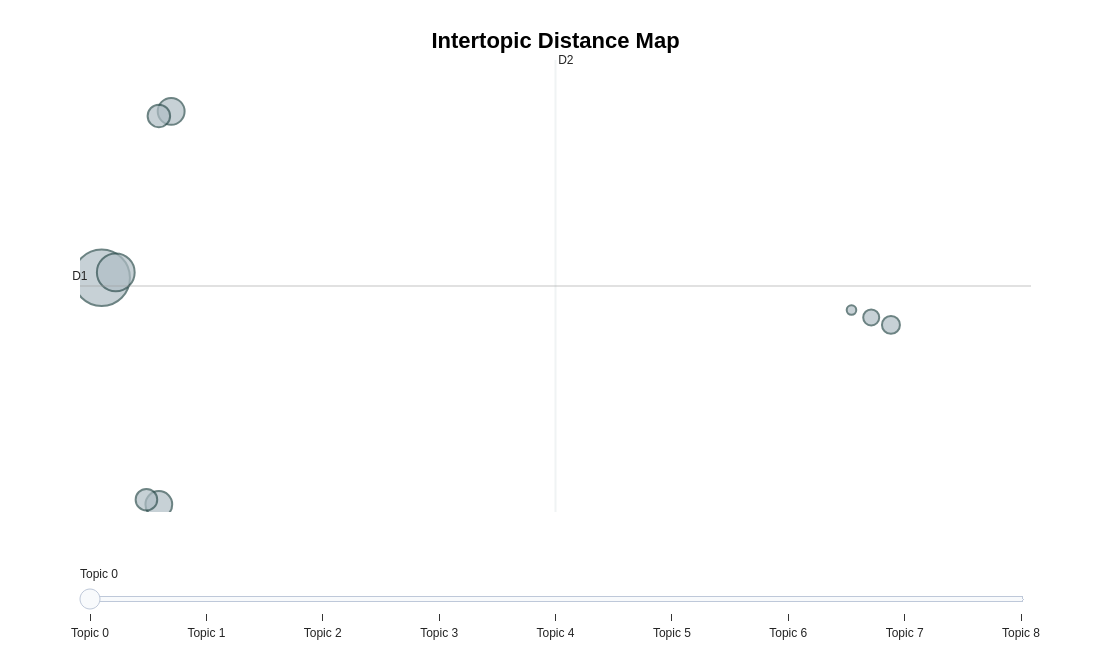

In [40]:
# === Topic Dist Map ===
topic_model.visualize_topics()

In [41]:
# === NPMI, UMASS, Diversity ===


# === Get expanded topics ===
topic_ids = list(topic_model.get_topics().keys())
expanded_topics = []
for topic_id in topic_ids:
    if topic_id != -1:
        words_scores = topic_model.get_topic(topic_id)[:10]  # Top 30 words per topic
        words_only = [word for word, _ in words_scores]
        expanded_topics.append(words_only)

# === Prepare corpus ===
texts = [doc.split() for doc in final_docs]

# === Build dictionary + BOW corpus ===
id2word = Dictionary(texts)
bow_corpus = [id2word.doc2bow(text) for text in texts]

# === Compute Per-topic NPMI Coherence ===
coherence_model = CoherenceModel(
    topics=expanded_topics,
    texts=texts,
    corpus=bow_corpus,
    dictionary=id2word,
    coherence='c_npmi'
)
individual_scores = coherence_model.get_coherence_per_topic()

print("\nTopic-Level NPMI Coherence Scores (Top 30 Words):")
for idx, score in enumerate(individual_scores):
    print(f"Topic {idx}: NPMI = {score:.4f}")

# === Compute u_mass Coherence Score ===
coherence_model_umass = CoherenceModel(
    topics=expanded_topics,
    texts=texts,
    corpus=bow_corpus,
    dictionary=id2word,
    coherence='u_mass'
)
individual_umass_scores = coherence_model_umass.get_coherence_per_topic()
overall_umass_score = coherence_model_umass.get_coherence()

# Output
print("\nTopic-Level UMass Coherence Scores:")
for idx, score in enumerate(individual_umass_scores):
    print(f"Topic {idx}: UMass = {score:.4f}")

print(f"\nOverall UMass Coherence Score: {overall_umass_score:.4f}")

# === Compute Global Topic Diversity ===
diversity = TopicDiversity(topk=10)
div_score = diversity.score({"topics": expanded_topics})
print(f"\nTopic Diversity Score (Top 30 Words): {div_score:.4f}")


Topic-Level NPMI Coherence Scores (Top 30 Words):
Topic 0: NPMI = 0.0281
Topic 1: NPMI = 0.0168
Topic 2: NPMI = 0.0906
Topic 3: NPMI = 0.1604
Topic 4: NPMI = 0.1901
Topic 5: NPMI = 0.0977
Topic 6: NPMI = 0.0653
Topic 7: NPMI = 0.1425
Topic 8: NPMI = 0.1001

Topic-Level UMass Coherence Scores:
Topic 0: UMass = -1.4935
Topic 1: UMass = -1.6315
Topic 2: UMass = -1.5233
Topic 3: UMass = -1.4526
Topic 4: UMass = -1.3524
Topic 5: UMass = -1.7547
Topic 6: UMass = -1.8299
Topic 7: UMass = -1.3423
Topic 8: UMass = -2.0322

Overall UMass Coherence Score: -1.6014

Topic Diversity Score (Top 30 Words): 0.8667


In [42]:
# === BERTopic on Specific Topic ===


# If not already a NumPy array
final_embeddings = np.array(final_embeddings)

# Filter docs belonging to a specific topic
target_topic = 0
indices = [i for i, t in enumerate(topics) if t == target_topic]
topic_docs = [final_docs[i] for i in indices]
topic_embeddings = final_embeddings[indices]  # <-- this line must use a NumPy array

#hdbscan
min_cluster_size = 15
min_samples = 20
sub_custom_hdbscan = hdbscan.HDBSCAN(
    min_cluster_size=min_cluster_size, 
    min_samples=min_samples,
    prediction_data=True
)


#Sub-Vectorizer
custom_stopwords = list(ENGLISH_STOP_WORDS.union({
    'flight', 'airline', 'airways', 'ba', 'british', 'seat', 'said'
}))
sub_vectorizer_model = CountVectorizer(
    stop_words=custom_stopwords,
    #min_df=5,
    #max_df=.90
)

# Create a sub-model
sub_topic_model = BERTopic(
    embedding_model=None,
    hdbscan_model=sub_custom_hdbscan,
    vectorizer_model=sub_vectorizer_model,
    calculate_probabilities=True,
    verbose=True,
    top_n_words=30
)

sub_topics, _ = sub_topic_model.fit_transform(topic_docs, topic_embeddings)

sub_topic_info = sub_topic_model.get_topic_info()
sub_topic_model.get_topic_info()

2025-05-29 15:07:39,300 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-05-29 15:07:42,542 - BERTopic - Dimensionality - Completed ✓
2025-05-29 15:07:42,543 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-05-29 15:07:42,669 - BERTopic - Cluster - Completed ✓
2025-05-29 15:07:42,679 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-05-29 15:07:43,052 - BERTopic - Representation - Completed ✓


,Topic,Count,Name,Representation,Representative_Docs
0,-1,206,-1_mr_bn_year_government,"[mr, bn, year, government, new, bank, ukip, pr...",[terror powers expose tyranny the lord chancel...
1,0,231,0_mr_labour_election_blair,"[mr, labour, election, blair, party, brown, pe...",[labour seeks to quell feud talk labours leade...
2,1,95,1_lord_home_mr_law,"[lord, home, mr, law, lords, police, people, r...",[opposition grows to house arrests the conserv...
3,2,92,2_bn_firm_company_lse,"[bn, firm, company, lse, shares, ebbers, bid, ...",[german bidder in talks with lse deutsche boer...
4,3,57,3_growth_economy_rates_rate,"[growth, economy, rates, rate, year, economic,...",[consumer spending lifts us growth us economic...
5,4,50,4_yukos_oil_russian_gazprom,"[yukos, oil, russian, gazprom, bn, yugansk, ro...",[yukos bankruptcy not us matter russian author...
6,5,37,5_airlines_air_boeing_fuel,"[airlines, air, boeing, fuel, airbus, passenge...",[aviation firms eye booming india indias defen...
7,6,30,6_car_gm_fiat_sales,"[car, gm, fiat, sales, bmw, year, cars, bn, ve...",[gm ford cut output as sales fall us car firms...
8,7,27,7_dollar_deficit_budget_bn,"[dollar, deficit, budget, bn, euro, trade, cur...",[markets fall on weak dollar fears rising oil ...
9,8,25,8_countries_world_aid_africa,"[countries, world, aid, africa, nations, brown...",[blair told to double overseas aid tony blair ...


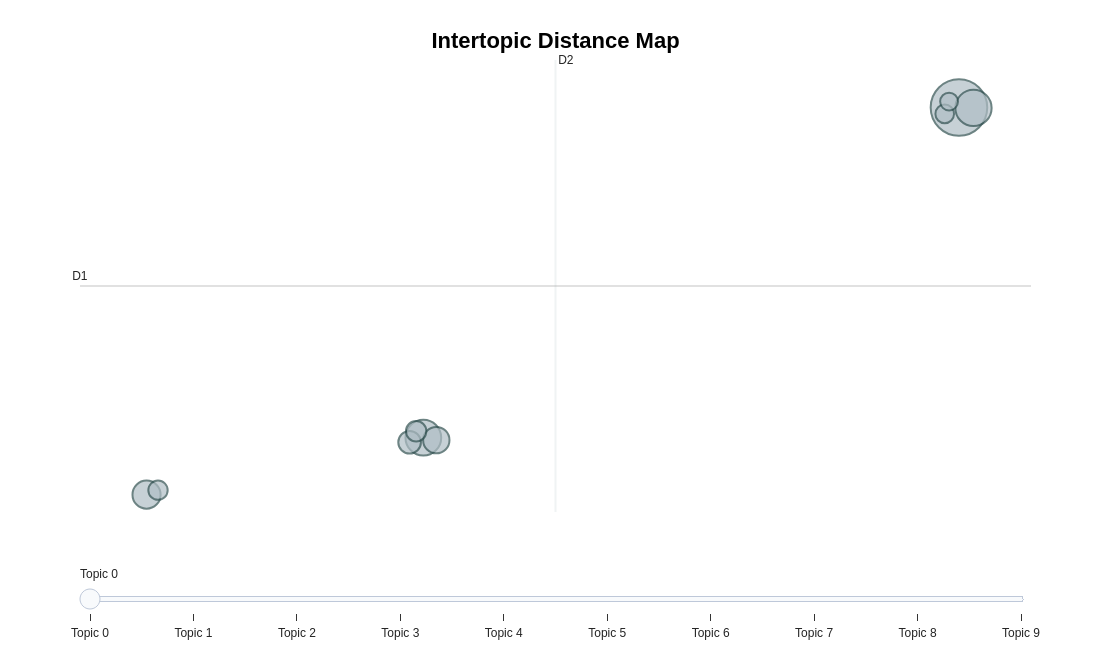

In [43]:
# === Sub Topic Dist Map ===
sub_topic_model.visualize_topics()

In [44]:
# === Sub Topic NPMI, UMASS, Diversity ===

# === Get expanded topics ===
topic_ids = list(sub_topic_model.get_topics().keys())
expanded_topics = []
for topic_id in topic_ids:
    if topic_id != -1:
        words_scores = sub_topic_model.get_topic(topic_id)[:10]  # Top 30 words per topic
        words_only = [word for word, _ in words_scores]
        expanded_topics.append(words_only)

# === Prepare corpus ===
texts = [doc.split() for doc in final_docs]

# === Build dictionary + BOW corpus ===
id2word = Dictionary(texts)
bow_corpus = [id2word.doc2bow(text) for text in texts]

# === Compute Per-topic NPMI Coherence ===
coherence_model_npmi = CoherenceModel(
    topics=expanded_topics,
    texts=texts,
    corpus=bow_corpus,
    dictionary=id2word,
    coherence='c_npmi'
)

individual_scores = coherence_model_npmi.get_coherence_per_topic()

print("\nTopic-Level NPMI Coherence Scores (Top 30 Words):")
for idx, score in enumerate(individual_scores):
    print(f"Topic {idx}: NPMI = {score:.4f}")


# === Compute U_mass coherence score ===
coherence_model_umass = CoherenceModel(
    topics=expanded_topics,
    texts=texts,
    corpus=bow_corpus,
    dictionary=id2word,
    coherence='u_mass'
)
individual_umass_scores = coherence_model_umass.get_coherence_per_topic()
overall_umass_score = coherence_model_umass.get_coherence()

# Output
print("\nTopic-Level UMass Coherence Scores:")
for idx, score in enumerate(individual_umass_scores):
    print(f"Topic {idx}: UMass = {score:.4f}")

print(f"\nOverall UMass Coherence Score: {overall_umass_score:.4f}")

# === Compute Global Topic Diversity ===
diversity = TopicDiversity(topk=10)
div_score = diversity.score({"topics": expanded_topics})
print(f"\nTopic Diversity Score (Top 30 Words): {div_score:.4f}")



Topic-Level NPMI Coherence Scores (Top 30 Words):
Topic 0: NPMI = 0.1029
Topic 1: NPMI = -0.0054
Topic 2: NPMI = 0.0597
Topic 3: NPMI = 0.1521
Topic 4: NPMI = 0.2900
Topic 5: NPMI = 0.0286
Topic 6: NPMI = 0.1453
Topic 7: NPMI = 0.1093
Topic 8: NPMI = 0.1332
Topic 9: NPMI = 0.0989

Topic-Level UMass Coherence Scores:
Topic 0: UMass = -1.0874
Topic 1: UMass = -1.4256
Topic 2: UMass = -3.2773
Topic 3: UMass = -1.5291
Topic 4: UMass = -0.9824
Topic 5: UMass = -3.9899
Topic 6: UMass = -2.5395
Topic 7: UMass = -1.6399
Topic 8: UMass = -1.9214
Topic 9: UMass = -1.9612

Overall UMass Coherence Score: -2.0354

Topic Diversity Score (Top 30 Words): 0.8700


BERTopic Grid Search: 100%|███████████████████| 361/361 [40:09<00:00,  6.67s/it]


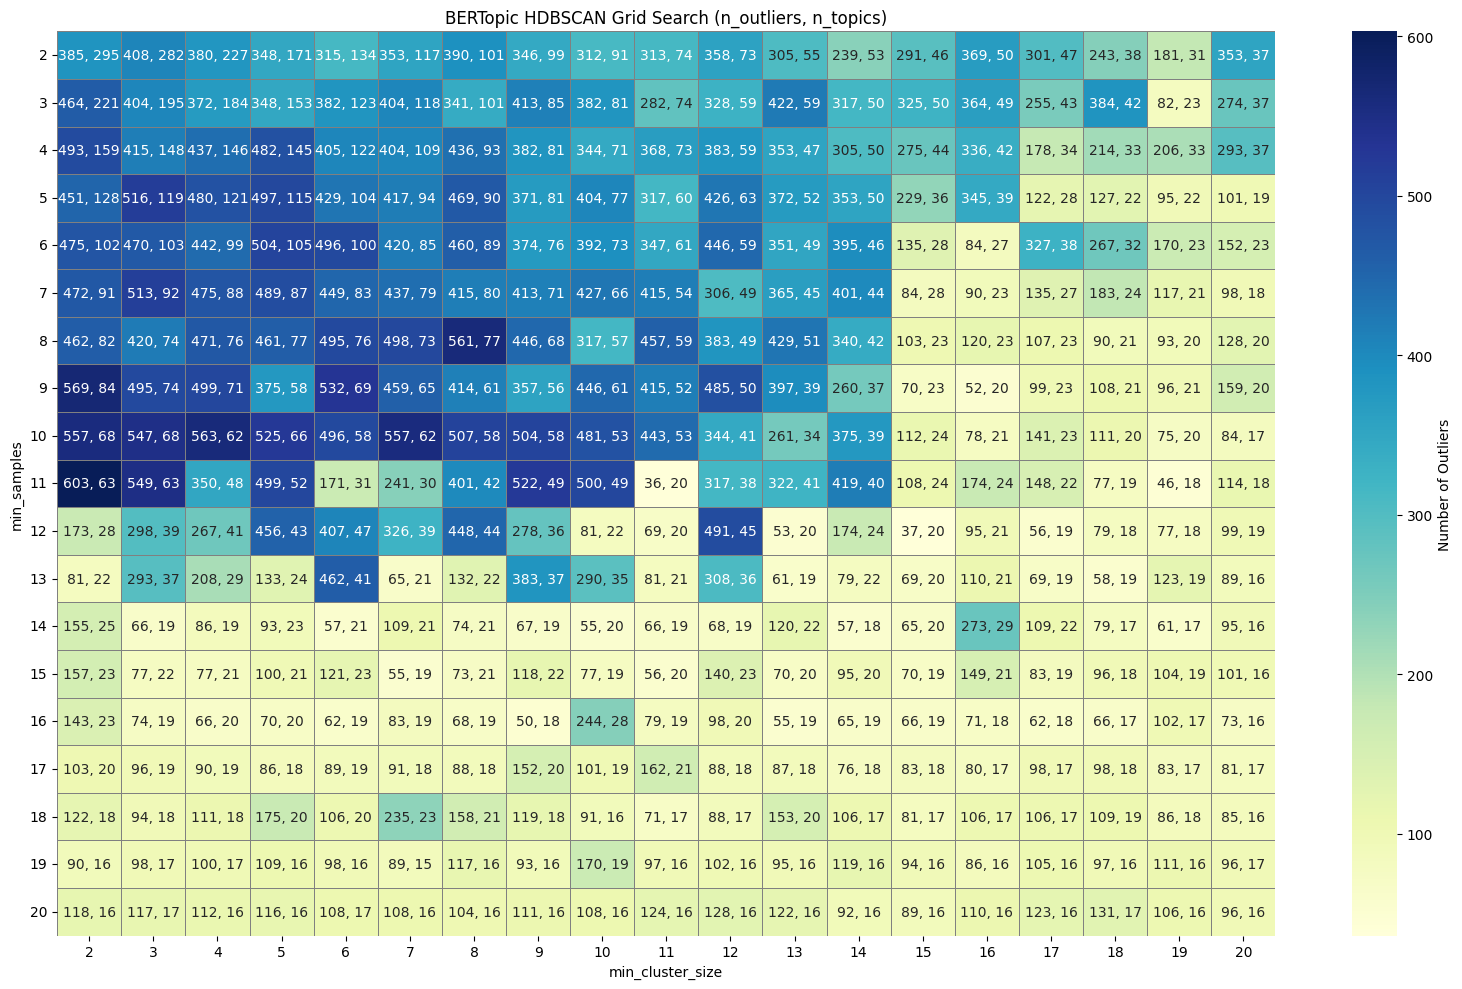

In [91]:
######DO NOT RUN AGAIN###### === Cluster and Sample Heatmap === ######DO NOT RUN AGAIN######

min_cluster_sizes = range(2, 21)
min_samples_values = range(2, 21)
param_grid = list(product(min_cluster_sizes, min_samples_values))

results = []

for min_cluster_size, min_samples in tqdm(param_grid, desc="BERTopic Grid Search", total=len(param_grid)):
    custom_hdbscan = hdbscan.HDBSCAN(
        min_cluster_size=min_cluster_size,
        min_samples=min_samples,
        prediction_data=True
    )

    topic_model = BERTopic(
        embedding_model=None,
        hdbscan_model=custom_hdbscan,
        vectorizer_model=vectorizer_model,
        calculate_probabilities=True,
        verbose=False
    )

    topics, probs = topic_model.fit_transform(final_docs, final_embeddings)

    n_outliers = topics.count(-1)
    n_topics = len(set(topics)) - (1 if -1 in topics else 0)

    results.append({
        "min_cluster_size": min_cluster_size,
        "min_samples": min_samples,
        "n_outliers": n_outliers,
        "n_topics": n_topics
    })

df = pd.DataFrame(results)

pivot_outliers = df.pivot(index="min_samples", columns="min_cluster_size", values="n_outliers")
pivot_topics = df.pivot(index="min_samples", columns="min_cluster_size", values="n_topics")

annot = pivot_outliers.astype(str) + ", " + pivot_topics.astype(str)

plt.figure(figsize=(16, 10))
sns.heatmap(
    pivot_outliers,
    annot=annot,
    fmt='',
    cmap="YlGnBu",
    cbar_kws={'label': 'Number of Outliers'},
    linewidths=0.5,
    linecolor='gray'
)

plt.title("BERTopic HDBSCAN Grid Search (n_outliers, n_topics)")
plt.xlabel("min_cluster_size")
plt.ylabel("min_samples")
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


In [45]:
# === LLM Topic Name ===
def create_chat_chain(model_name="tinyllama", temperature=0.7):
    prompt = ChatPromptTemplate.from_template(
    """You are a helpful assistant that creates short, **broad** topic names.
Use the keywords provided to choose a general category or theme that best represents the topic.

Keywords:
{context}

Respond with a topic name using **1–2 words only**, and make it **broad** (e.g., 'Technology', 'Travel', 'Health'). 
If there appears to be 2 main topics, respond with XXX.
Do not explain your reasoning, simply just provide the topic name.
"""
)
    model = OllamaLLM(model=model_name, temperature=temperature)
    chain = prompt | model
    return chain

def generate_topic_names_with_llm(topic_model, model_name="llama3", temperature=0.0):
    topic_info = topic_model.get_topic_info()
    llm_names = []

    chain = create_chat_chain(model_name=model_name, temperature=temperature)

    for topic_id in tqdm(topic_info["Topic"]):
        if topic_id == -1:
            llm_names.append("Noise / Uncategorized")
            continue

        keywords = [word for word, _ in topic_model.get_topic(topic_id)]
        docs = topic_model.get_representative_docs(topic_id)[:3]

        context = f"Keywords: {', '.join(keywords)}\n"
        user_prompt = "Generate a name for this topic"

        try:
            result = chain.invoke({
                "context": context,
                "question": user_prompt
            })
            llm_names.append(result.strip())
        except Exception as e:
            llm_names.append(f"Error: {e}")

    col_index = topic_info.columns.get_loc("Name")
    before = topic_info.iloc[:, :col_index + 1]
    after = topic_info.iloc[:, col_index + 1:]
    topic_info = pd.concat([before, pd.Series(llm_names, name="LLM Name"), after], axis=1)

    return topic_info

updated_topic_info = generate_topic_names_with_llm(topic_model)

updated_topic_info[["Topic", "Count", "Name", "LLM Name"]]


100%|███████████████████████████████████████████| 10/10 [00:03<00:00,  2.84it/s]


,Topic,Count,Name,LLM Name
0,-1,22,-1_book_prize_award_winner,Noise / Uncategorized
1,0,873,0_mr_government_bn_blair,Politics
2,1,389,1_technology_games_music_phone,Media
3,2,197,2_club_united_game_league,Sports
4,3,195,3_film_best_actor_films,Entertainment
5,4,138,4_england_wales_ireland_nations,Rugby
6,5,127,5_music_band_best_rock,Rock Music
7,6,88,6_match_beat_second_cup,Tennis
8,7,70,7_race_olympic_champion_championships,Olympics
9,8,25,8_greek_drugs_tests_test,Sports


In [104]:
# === Remove Topic to CSV ===

outlier_indices = [i for i, topic in enumerate(topics) if topic == 0] # specify to which topic

outlier_docs = [docs[i] for i in outlier_indices]



df_outliers = pd.DataFrame({
    "Document": [docs[i] for i in outlier_indices],
    "Index": outlier_indices,
})
df_outliers.to_csv("bertopic_BBC_dispro_large.csv", index=False) # change csv name accordingly